# Preliminaries

In [49]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [50]:
#Load original dataframes
allDataOrig = pd.read_csv("Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM') #all feature dataset
hemoOrig = pd.read_csv("Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM') #dataset with only hemodynamics
classLabels  = pd.read_csv("Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM') #labels for prediction classes 

# Cluster Labels

In [51]:
#CLUSTERING FUNCTIONS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)
    
def kMeans(X, K): #perform k means clustering
    km = KMeans(n_clusters=K, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    print("Lowest SSE", km.inertia_) #lowest sum of squared error value
    print("Number of iterations needed for convergence", km.n_iter_) #number of iterations neded to converge
    print("Y_km labels", y_km)
    
    return y_km

def plotPCAClusters(X, y_km, K): #plot clusters from pca
    df = pd.DataFrame(X, columns=["component_1", "component_2"])
    df['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='component_1', y='component_2', hue='cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.show()
    
    return df

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

        print("Cluster ", num)
        print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

#compare distributions of clusters
def distPlotsForClusters(cls, cols):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Figures/Clusters"+c+".png")

## Hemo Dataset

In [52]:
#try clustering to find similar groups using PCA
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
scaler = MinMaxScaler()#scale data
hemo.loc[:,:] = scaler.fit_transform(hemo)
pca = PCA(n_components=2)
data = pca.fit_transform(hemo)

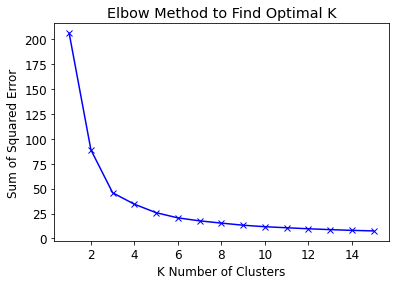

Using the elbow method, the optimal number of clusters is 3


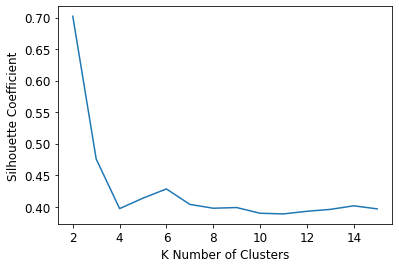

Using Silhouette Scores, the optimal number of clusters is 2


In [53]:
clusterFindK(data)

Lowest SSE 25.831284441802524
Number of iterations needed for convergence 16
Y_km labels [0 4 2 2 4 2 4 3 4 1 0 1 1 3 3 2 1 3 1 1 4 4 4 1 0 1 0 3 1 1 1 3 1 2 4 4 4
 1 2 2 0 4 4 1 4 1 4 1 1 1 4 1 1 3 0 2 0 4 4 1 1 1 1 3 0 4 4 1 1 3 1 4 1 3
 0 3 4 1 4 1 1 4 0 1 1 1 1 1 2 1 4 4 1 2 3 1 0 3 1 1 1 1 4 4 4 2 4 2 4 1 4
 4 0 3 4 1 4 1 3 1 4 2 2 1 1 1 1 1 0 1 1 1 1 1 4 2 4 1 4 1 0 4 4 1 0 1 1 1
 4 1 4 1 0 4 1 2 4 3 2 4 4 3 4 1 0 4 1 1 1 3 4 1 2 2 1 1 0 4 4 1 4 4 1 1 4
 1 4 1 4 1 4 2 3 1 2 2 4 1 0 4 1 2 4 1 1 2 4 1 1 1 4 1 1 1 0 1 4 4 0 4 1 2
 4 3 1 1 1 1 4 1 4 4 1 1 4 3 4 2 1 2 4 1 0 2 2 2 4 1 1 3 4 2 4 1 4 3 4 1 0
 4 4 1 4 1 0 4 0 3 3 1 4 1 0 4 0 1 2 2 4 1 4 1 0 2 4 4 4 4 1 1 2 2 1 1 4 1
 2 2 4 1 0 4 4 4 0 4 0 4 0 4 4 2 4 1 2 1 4 1 4 1 4 4 0 3 4 1 4 4 0 4 4 1 4
 3 4 3 4 1 0 4 1 1 0 4 2 1 3 2 0 4 0 0 4 4 4 4 1 4 0 3 4 1 0 1 1 3 0 0 0 2
 0 4 4 4 0 0 4 4 0 4 0 1 4 1 4 4 4 1 2 2 0 4 0 1 0 1 1 4 3 1 1 1 0 0 4 2 2
 3 0 0 4 1 2 3 0 4 4 4]


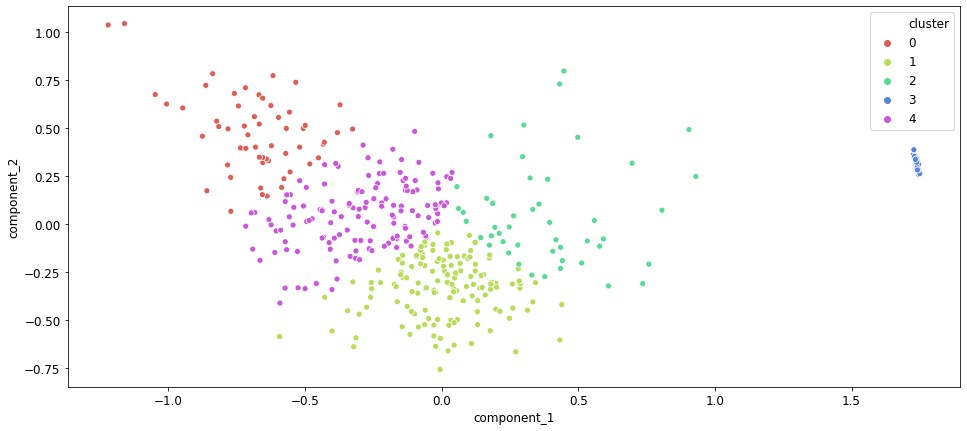

In [54]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5)

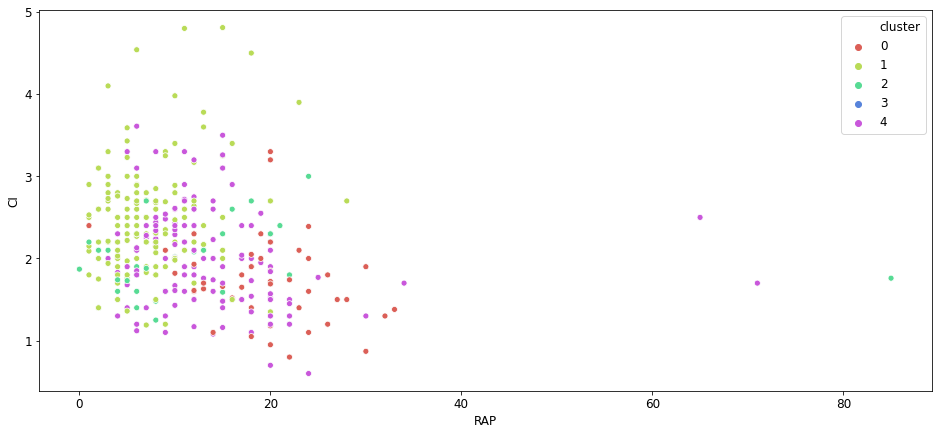

In [55]:
#Look at original data clusters
hemoDF = plotClusters(hemoOrig, y_km, ["RAP", "CI"], 5)

In [56]:
#Add class labels
hemoDF['Death'] = classLabels['Death']
hemoDF['Rehosp'] = classLabels['Rehosp']
hemoDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(hemoDF, 5)

Cluster  0
             RAP        PAS        PAD       PAMN        CWP    PCWPMod  \
count  56.000000  57.000000  57.000000  57.000000  57.000000  57.000000   
mean   18.553571  68.526316  37.877193  48.017544  34.947368  34.947368   
std     6.412827  10.380451   6.758778   9.138793   6.434897   6.434897   
min     1.000000  42.000000  20.000000  16.000000  20.000000  20.000000   
25%    13.750000  63.000000  35.000000  43.000000  30.000000  30.000000   
50%    19.000000  69.000000  37.000000  49.000000  35.000000  35.000000   
75%    22.250000  74.000000  42.000000  53.000000  39.000000  39.000000   
max    33.000000  90.000000  59.000000  82.000000  53.000000  53.000000   

           PCWPA     PCWPMN         CO         CI  ...       PAPP  \
count  46.000000  46.000000  55.000000  54.000000  ...  57.000000   
mean   35.217391  33.891304   3.516000   1.748519  ...   0.441638   
std     7.001311   5.275639   1.048398   0.489522  ...   0.093725   
min    20.000000  20.000000   1.68000

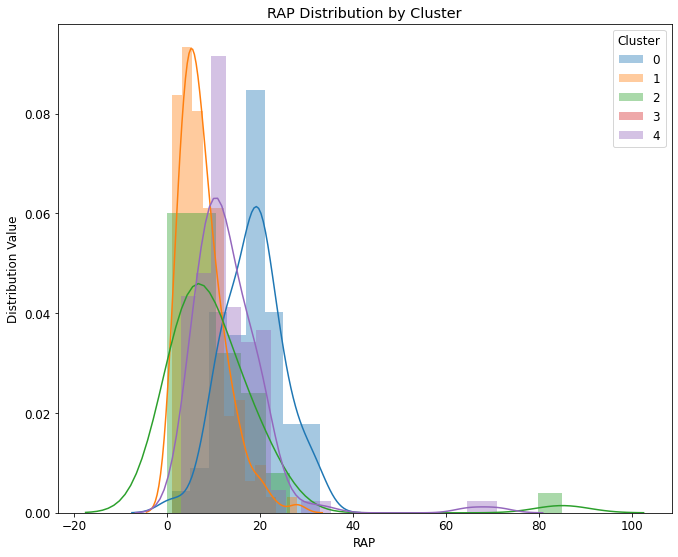

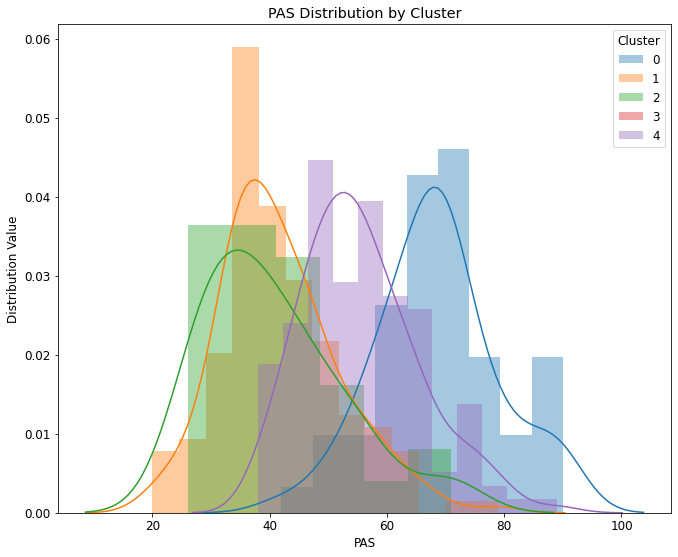

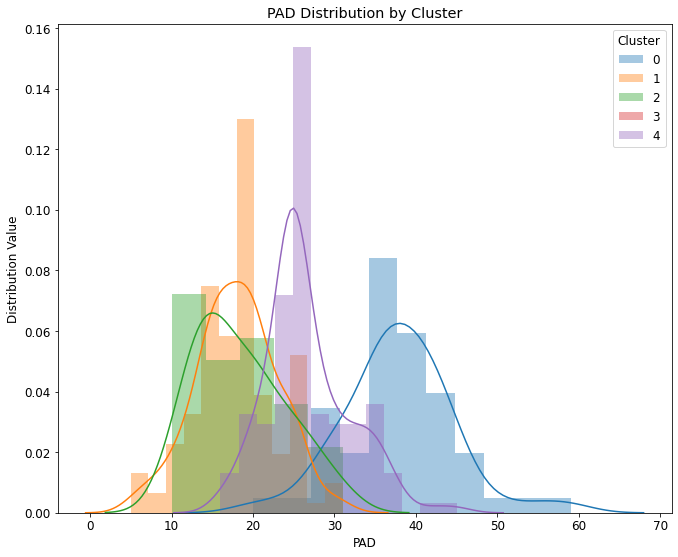

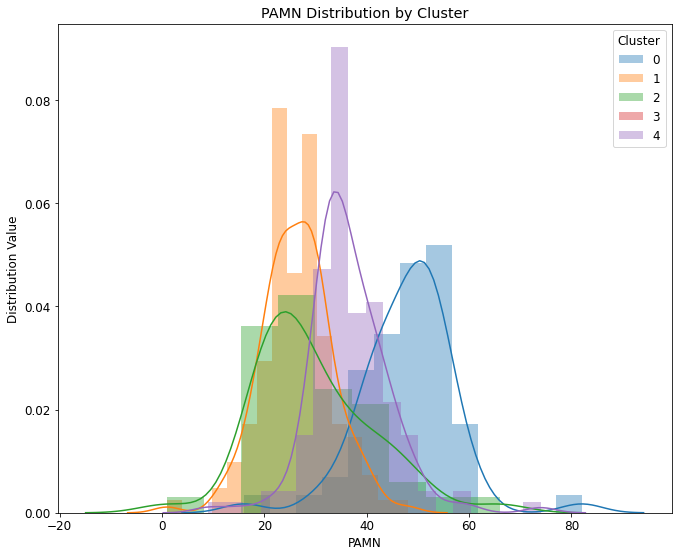

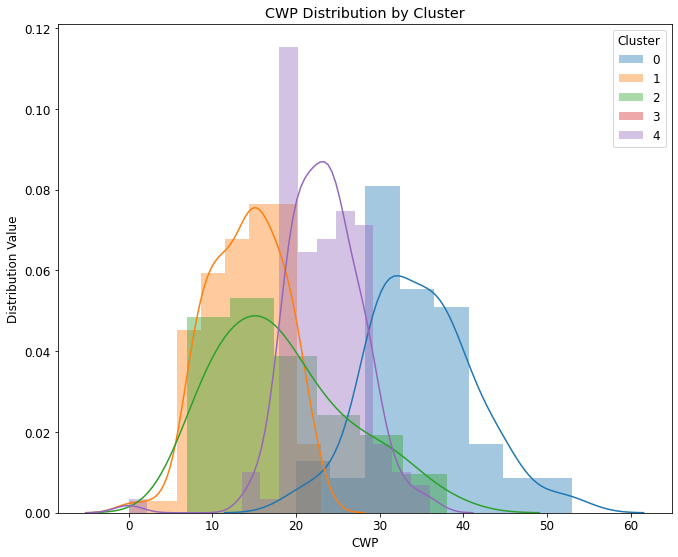

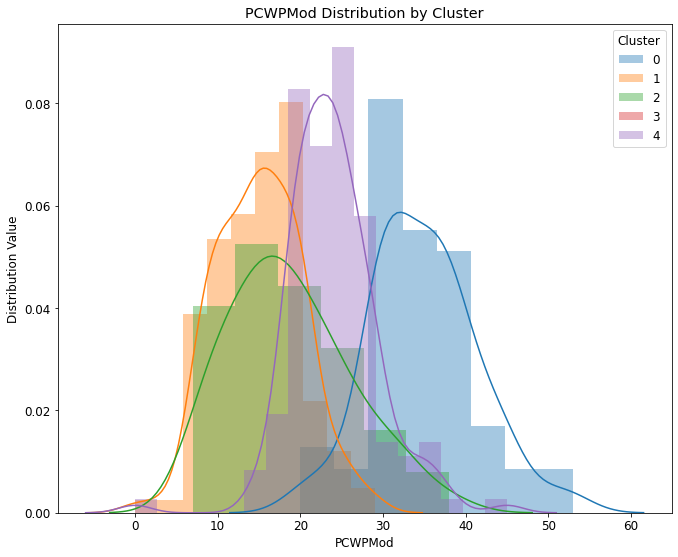

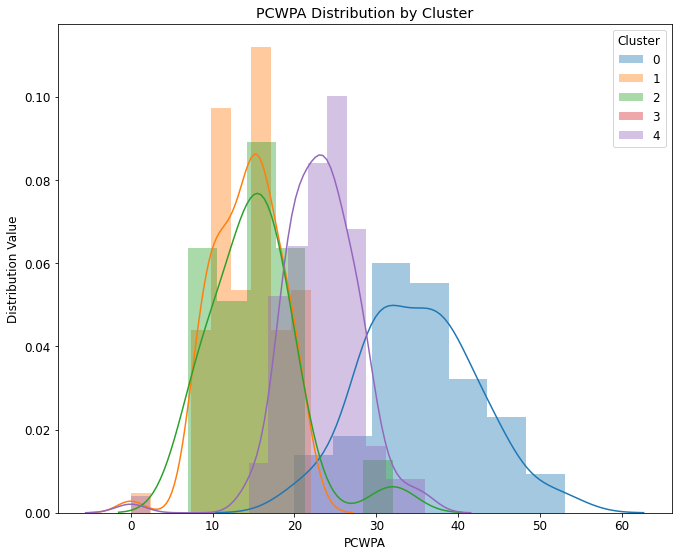

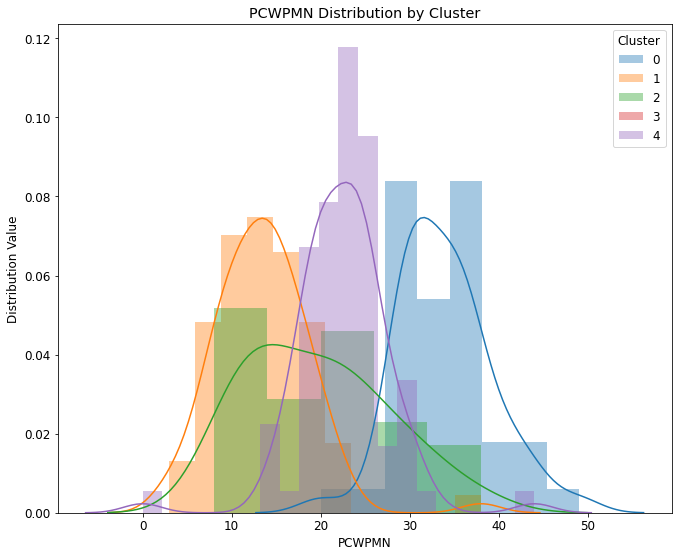

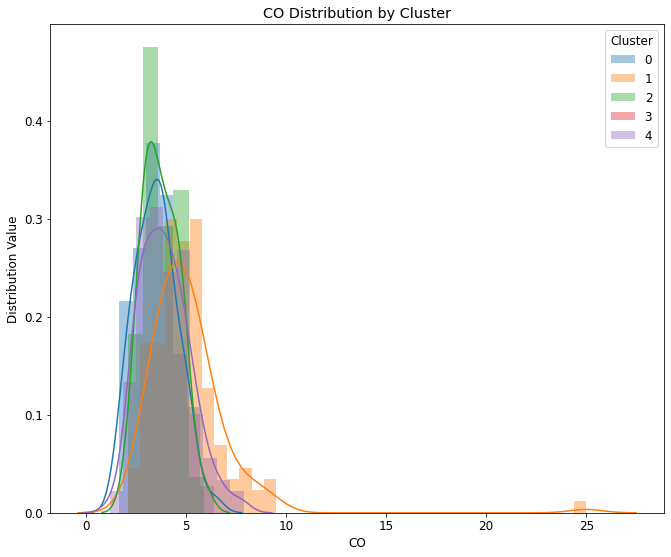

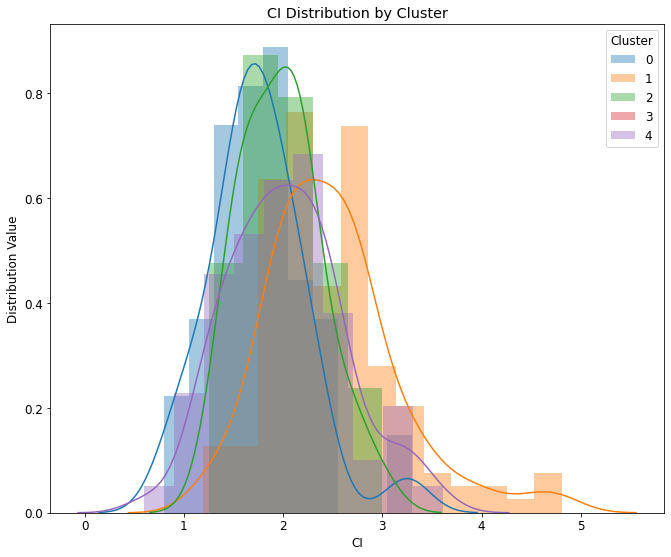

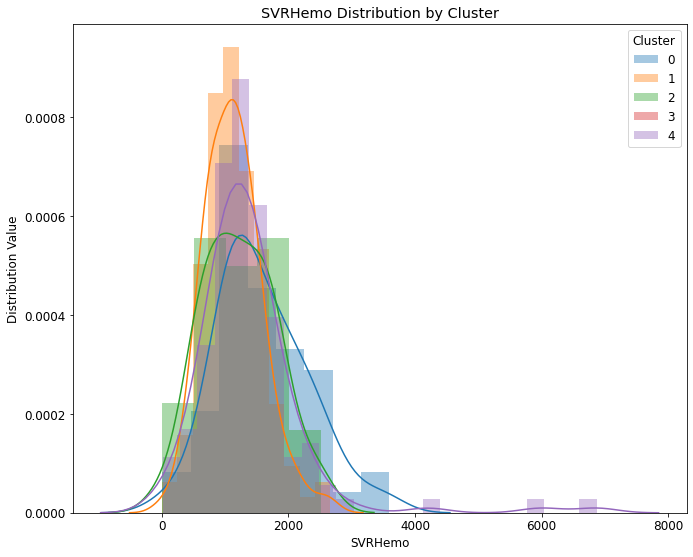

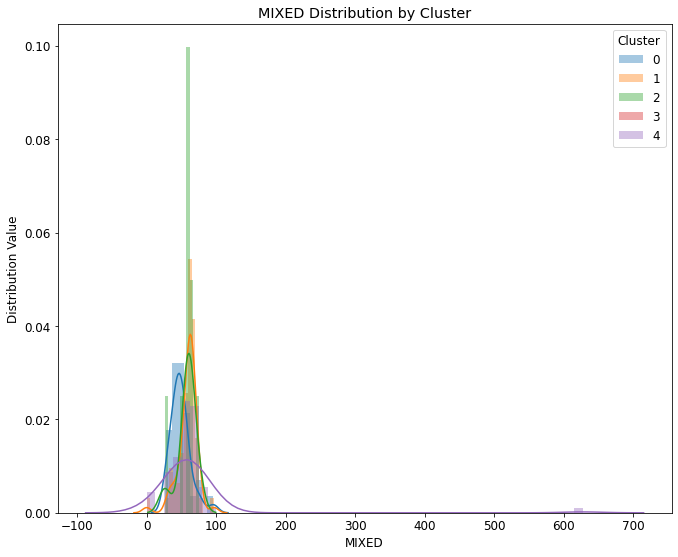

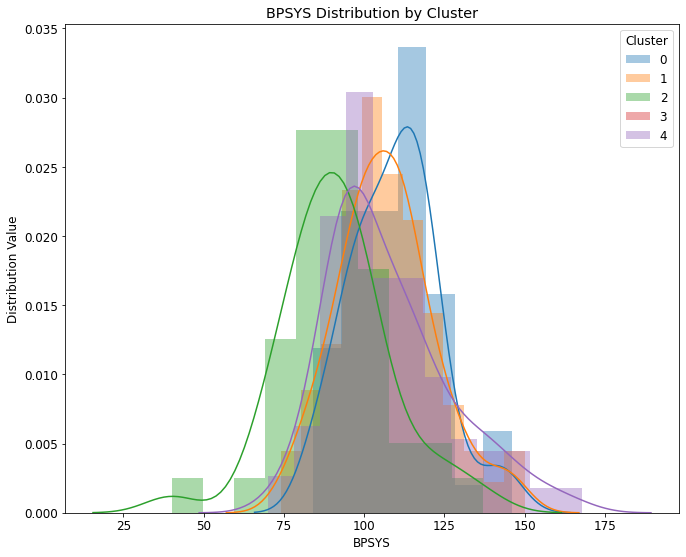

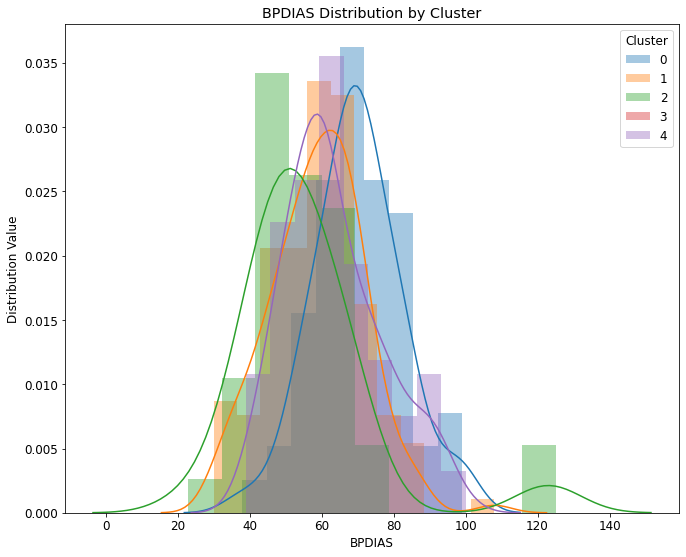

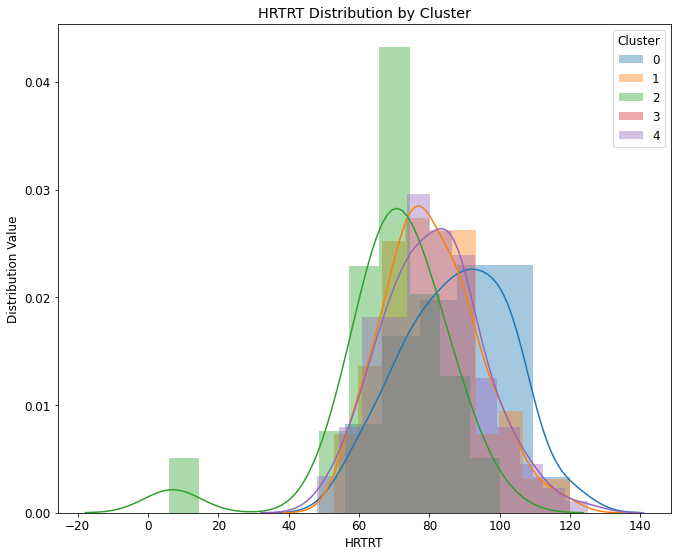

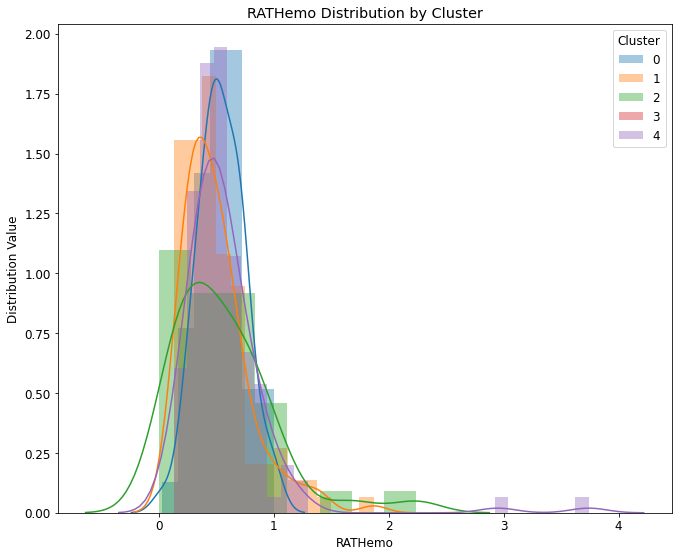

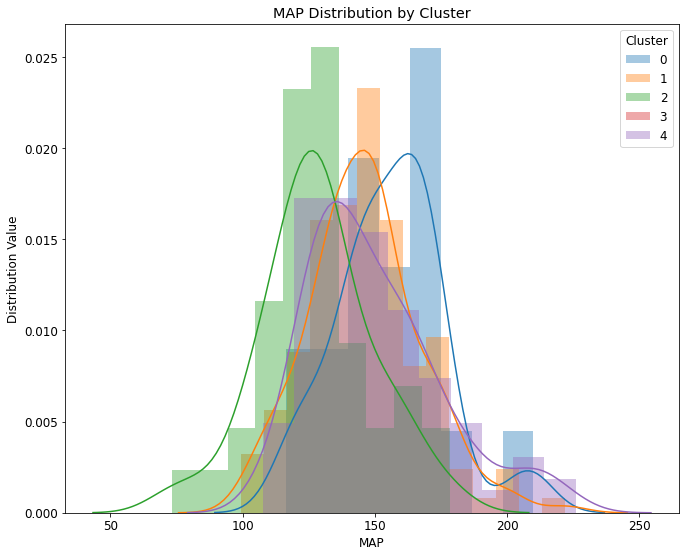

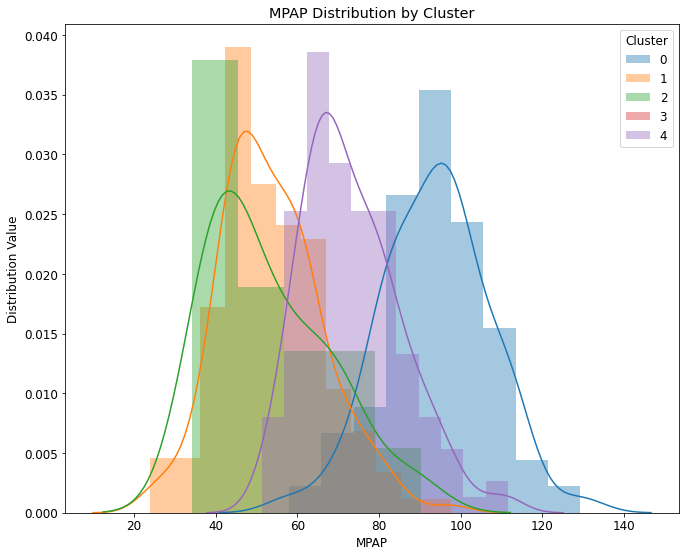

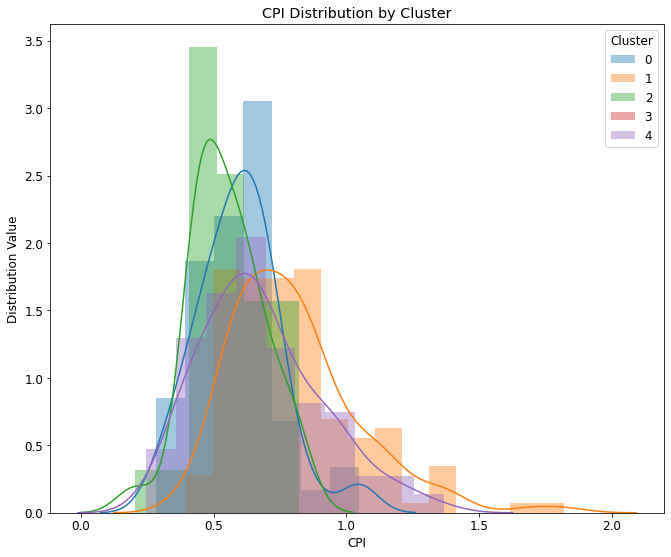

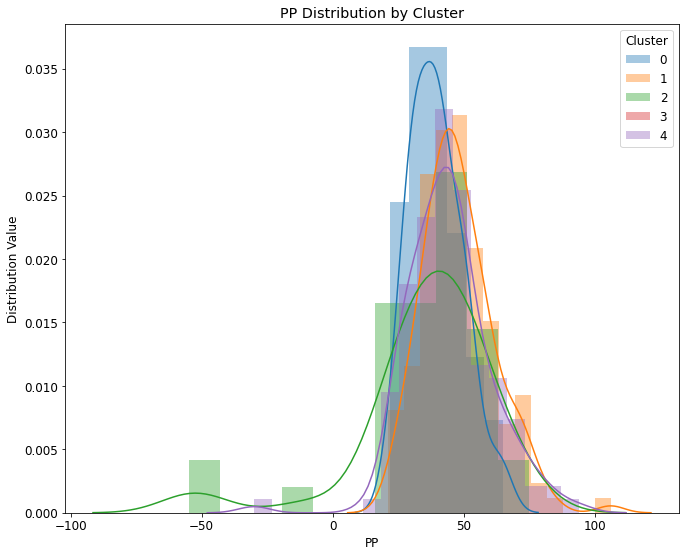

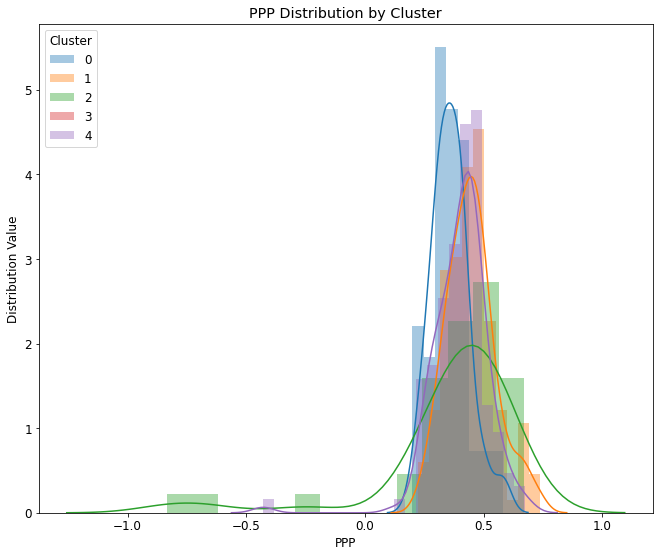

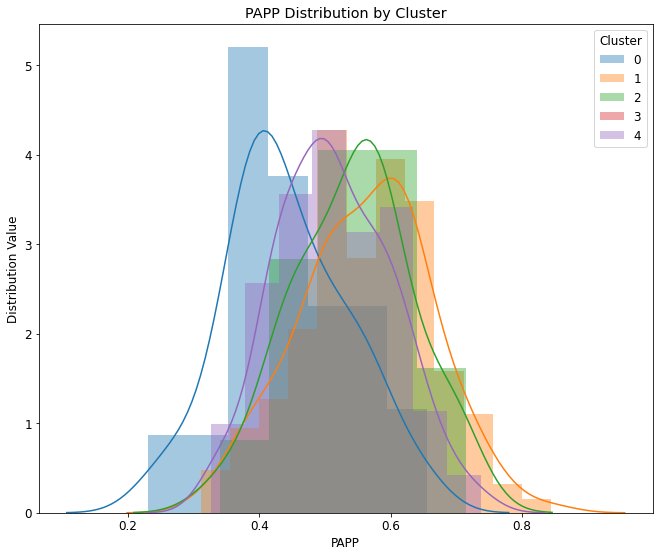

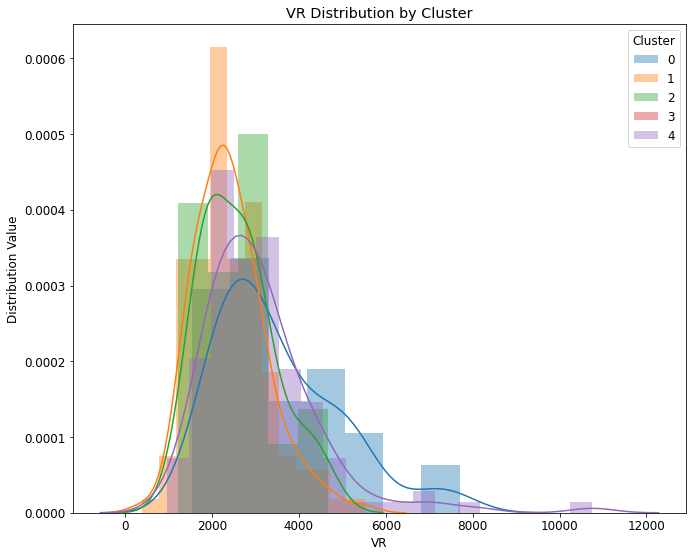

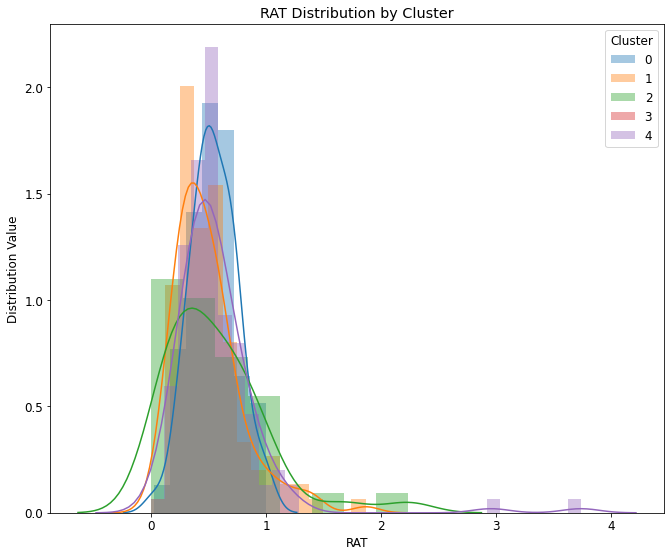

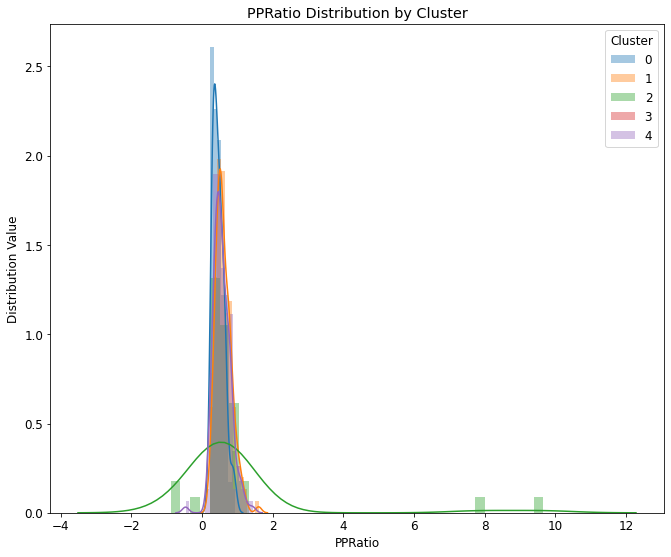

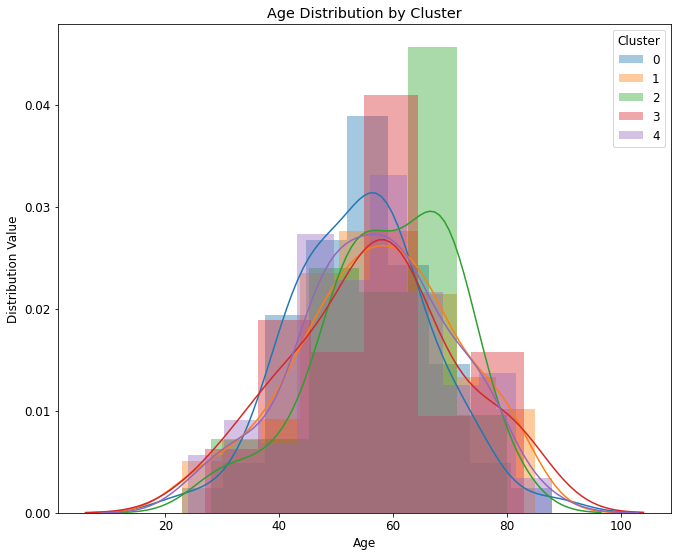

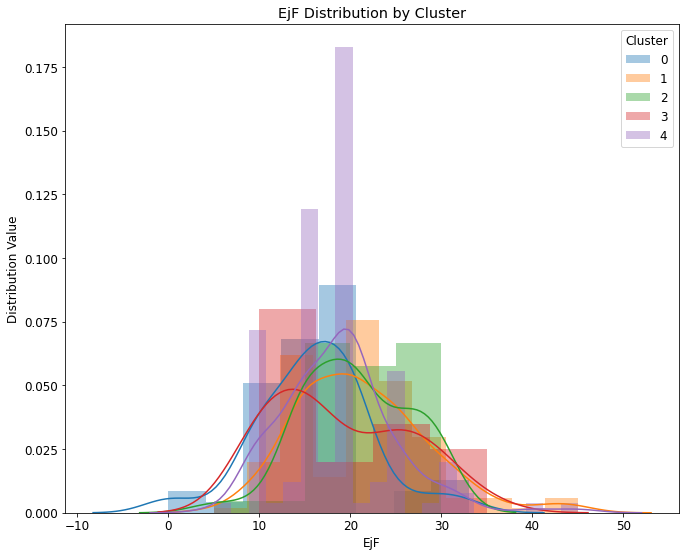

In [57]:
colss = ['RAP', 'PAS', 'PAD', 'PAMN', 'CWP', 'PCWPMod', 'PCWPA', 'PCWPMN', 'CO',
       'CI', 'SVRHemo', 'MIXED', 'BPSYS', 'BPDIAS', 'HRTRT', 'RATHemo', 'MAP',
       'MPAP', 'CPI', 'PP', 'PPP', 'PAPP', 'VR', 'RAT', 'PPRatio', 'Age',
       'EjF']

distPlotsForClusters(cls=clusters, cols=colss)

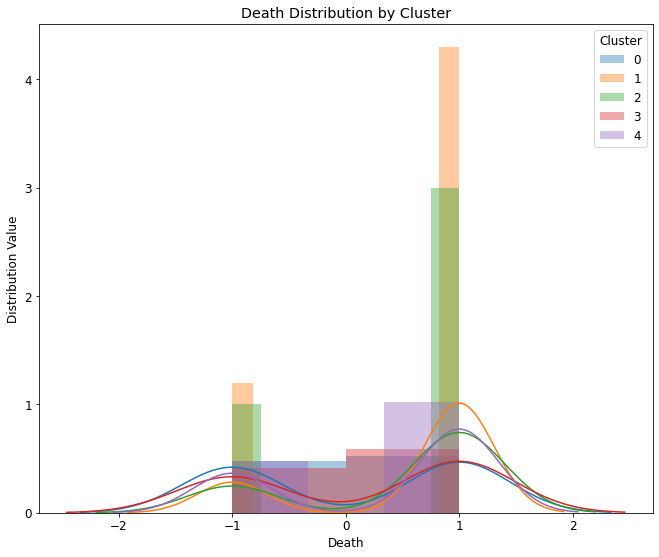

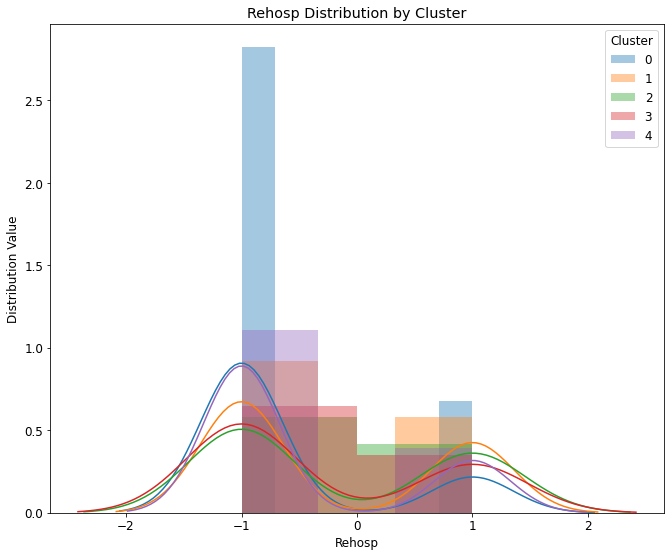

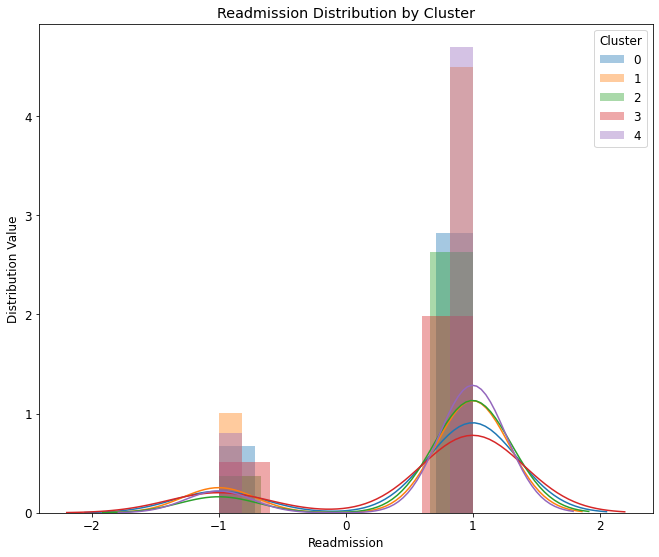

In [58]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss)

In [59]:


clsDict = {}
count = 1
clsOrder = [3,4,1,2,5]
for i in range(len(clusterDesc)):
    cluster = clusterDesc[clsOrder[i]-1]
    cluster = cluster.fillna(0)
    cluster = cluster.replace(np.inf, 0)
    for c in cluster:
        if count == 1:
            clsDict[c] = [cluster[c]['mean']]
        else:
            clsDict[c].append(cluster[c]['mean'])
    count+=1

clsDict

{'RAP': [10.617021276595745, 0.0, 18.553571428571427, 7.586956521739131, 13.4],
 'PAS': [40.72727272727273,
  0.0,
  68.52631578947368,
  41.61267605633803,
  55.55474452554745],
 'PAD': [18.363636363636363,
  0.0,
  37.87719298245614,
  18.007042253521128,
  26.598540145985403],
 'PAMN': [29.47826086956522,
  0.0,
  48.01754385964912,
  26.431654676258994,
  36.63970588235294],
 'CWP': [18.35,
  0.0,
  34.94736842105263,
  13.991869918699187,
  23.404580152671755],
 'PCWPMod': [18.75,
  0.0,
  34.94736842105263,
  15.02112676056338,
  24.014598540145986],
 'PCWPA': [15.0,
  0.0,
  35.21739130434783,
  14.154761904761905,
  23.307692307692307],
 'PCWPMN': [19.586206896551722,
  0.0,
  33.891304347826086,
  13.474358974358974,
  22.54320987654321],
 'CO': [3.7411111111111106,
  0.0,
  3.5160000000000005,
  5.093714285714286,
  3.9403731343283583],
 'CI': [1.9777777777777774,
  0.0,
  1.7485185185185186,
  2.491205673758865,
  2.0285496183206106],
 'SVRHemo': [1228.2777777777778,
  0.0,


In [60]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_Hemo.csv")

In [61]:
hemoDF.to_csv("Clustered_HemoDF.csv")

Save preprocessed data  
Cluster --> Score  
0 --> 5  
1 --> 2  
2 --> 1  
3 --> 4  
4 --> 3  

In [62]:
#Save fully preprocessed score data
clusNums = hemoDF['cluster']

labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
    
hemoDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
hemoDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(3)
    elif c == 4:
        labels.append(4)
    else:
        pass
hemoDF['ScoreRehosp'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(4)
    elif c == 1:
        labels.append(3)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(5)
    elif c == 4:
        labels.append(2)
    else:
        pass
hemoDF['ScoreReadmission'] = labels

hemoDF = hemoDF.drop(columns=["cluster"])
hemoDF = hemoDF.drop(columns=["Death"])
hemoDF = hemoDF.drop(columns=["Rehosp"])
hemoDF = hemoDF.drop(columns=["Readmission"])

hemoDF

RAP   PAS   PAD  PAMN   CWP  PCWPMod  PCWPA  PCWPMN    CO    CI  \
DEIDNUM                                                                     
72       24.0  42.0  24.0  30.0  36.0     36.0   36.0    36.0  2.20  1.60   
72       18.0  42.0  24.0  30.0  24.0     24.0   24.0    28.0  3.10  2.00   
81       10.0  40.0  20.0  27.0  18.0     18.0   18.0    20.0  4.52  2.02   
81       12.0  35.0  15.0  25.0  17.0     17.0   17.0    14.0  4.65  2.08   
814       3.0  51.0  19.0  30.0  18.0     18.0   18.0    18.0  4.10  2.00   
...       ...   ...   ...   ...   ...      ...    ...     ...   ...   ...   
98508     NaN   NaN   NaN   NaN   NaN      NaN    NaN     NaN   NaN   NaN   
99302    19.0  87.0  37.0  54.0  44.0     44.0   44.0     NaN  3.90  2.00   
99302    11.0  70.0  28.0  44.0  28.0     28.0   28.0     NaN  5.30  2.70   
99935     8.0  49.0  29.0  31.0  15.0     15.0   15.0    26.0  4.00  2.40   
99935     8.0  52.0  24.0  39.0  24.0     24.0   24.0    24.0  5.60  3.30   

         ...      PAPP           VR       RAT   PPRatio   Age   EjF  Score  \
DEIDNUM  ...                                                                 
72       ...  0.428571  5357.575758  0.666667  0.266667  88.0  25.0      5   
72       ...  0.428571  3509.677419  0.750000  0.272727  88.0  25.0      3   
81       ...  0.500000  1982.300885  0.555556  0.242857  69.0  20.0      1   
81       ...  0.571429  1772.043011  0.705882  0.571429  69.0  20.0      1   
814      ...  0.627451  2621.138211  0.166667  0.566667  58.0   NaN      3   
...      ...       ...          ...       ...       ...   ...   ...    ...   
98508    ...       NaN          NaN       NaN       NaN  57.0  30.0      4   
99302    ...  0.574713  2666.666667  0.431818  0.642857  41.0  15.0      5   
99302    ...  0.600000  2440.251572  0.392857  1.088608  41.0  15.0      3   
99935    ...  0.408163  3220.000000  0.533333  1.253333  64.0  20.0      3   
99935    ...  0.538462  1985.714286  0.333333  0.888889  64.0  20.0      3   

         ScoreDeath  ScoreRehosp  ScoreReadmission  
DEIDNUM                                             
72                5            5                 4  
72                3            4                 2  
81                2            1                 1  
81                2            1                 1  
814               3            4                 2  
...             ...          ...               ...  
98508             4            3                 5  
99302             5            5                 4  
99302             3            4                 2  
99935             3            4                 2  
99935             3            4                 2  

[418 rows x 31 columns]

In [63]:
hemoDF.to_csv("Preprocessed Data/Cluster_Hemo.csv")

## All Data

In [64]:
#try clustering to find similar groups using PCA
allData = copy.deepcopy(allDataOrig)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)
scaler = MinMaxScaler()#scale data
allData.loc[:,:] = scaler.fit_transform(allData)
pca = PCA(n_components=2)
data = pca.fit_transform(allData)

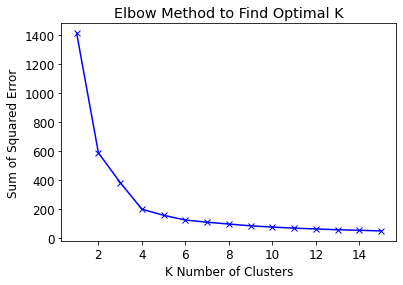

Using the elbow method, the optimal number of clusters is 4


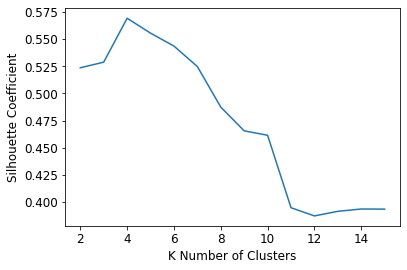

Using Silhouette Scores, the optimal number of clusters is 4


In [65]:
clusterFindK(data)

Lowest SSE 158.68591267461377
Number of iterations needed for convergence 7
Y_km labels [3 3 0 0 2 2 3 3 3 3 2 2 0 0 4 4 3 3 0 0 1 1 2 2 0 0 0 0 3 3 2 2 1 1 0 0 1
 1 3 3 1 1 2 2 3 3 2 2 0 0 3 3 2 2 1 1 3 3 1 1 3 3 3 3 0 0 4 4 3 3 3 3 3 3
 3 3 3 3 0 0 4 4 1 1 0 0 3 3 2 2 2 2 2 2 1 1 0 0 4 4 1 1 0 0 2 2 3 3 2 2 2
 2 2 2 0 0 3 3 3 3 3 3 0 0 2 2 2 2 3 3 1 1 2 2 2 2 2 2 1 1 2 2 2 2 3 3 3 3
 4 4 2 2 1 1 0 0 2 2 2 2 2 2 2 2 2 2 0 0 2 2 3 3 1 1 3 3 3 3 1 1 0 0 0 0 4
 4 2 2 2 2 3 3 4 4 0 0 0 0 0 0 2 0 3 3 3 3 0 0 3 3 0 0 1 1 1 1 1 1 1 1 1 1
 2 2 4 4 2 2 2 2 0 0 4 4 3 3 2 2 2 2 2 2 3 3 3 3 0 0 4 4 4 4 1 1 2 2 4 4 0
 0 4 4 3 3 0 0 1 1 2 2 1 1 1 1 1 1 1 1 3 3 1 1 3 3 4 4 3 3 0 0 3 3 3 3 2 2
 4 4 2 2 3 3 1 1 2 2 2 2 3 3 3 3 3 3 0 0 2 2 4 4 0 0 1 1 2 2 2 2 2 2 2 2 3
 3 3 3 0 0 3 3 3 3 0 0 0 0 2 2 0 0 4 4 4 4 2 2 4 4 1 1 0 0 0 0 1 1 4 4 2 2
 4 4 0 0 0 0 4 4 0 0 0 0 2 2 2 2 2 2 0 0 3 3 3 3 2 2 3 3 2 2 3 3 2 2 3 3 3
 3 3 3 1 1 2 2 2 2 1 1 3 3 2 2 2 2 4 4 0 0 2 2 2 2 2 2 1 1 2 2 0 0 1 1 4 4
 4 4 3 3 2 2

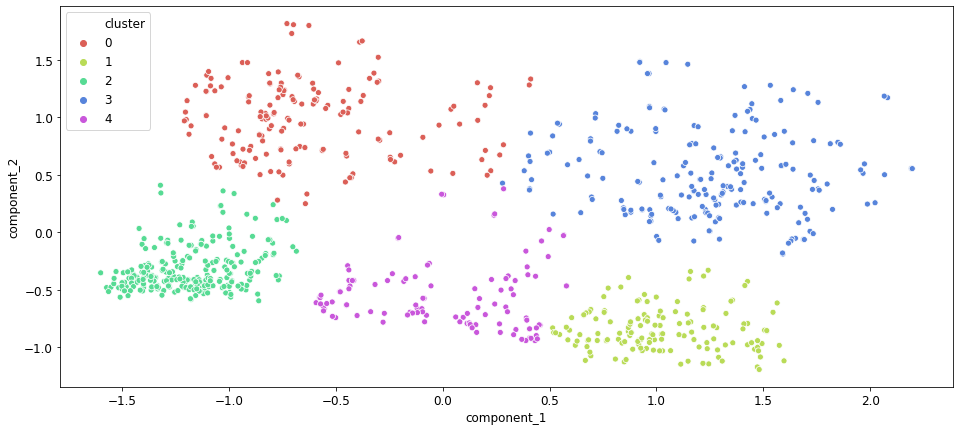

In [66]:
y_km = kMeans(data, 5)
pcaDF = plotPCAClusters(data, y_km, 5)

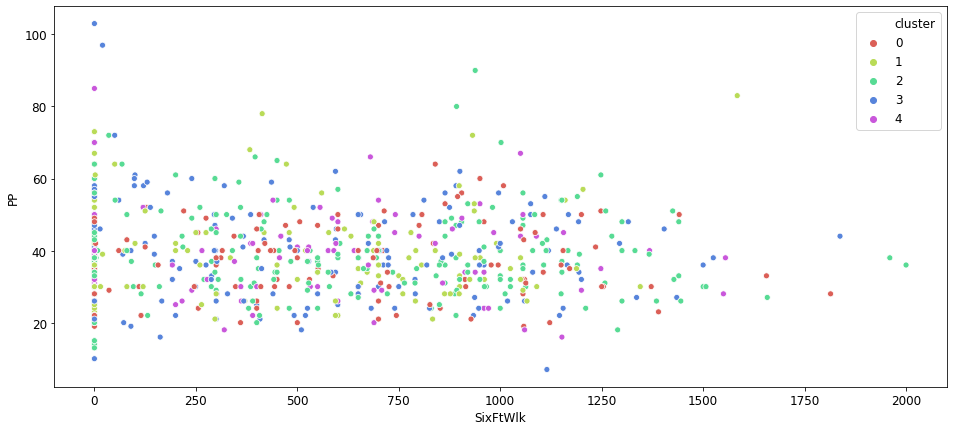

In [67]:
#Look at original data clusters
allDF = plotClusters(allDataOrig, y_km, ["SixFtWlk", "PP"], 5)

In [68]:
#Add class labels
allDF['Death'] = classLabels['Death']
allDF['Rehosp'] = classLabels['Rehosp']
allDF['Readmission'] = classLabels['Readmission']

clusters, clusterDesc = compareClusters(allDF, 5)

Cluster  0
              Age      Gender        Race          Wt         BMI  \
count  161.000000  161.000000  161.000000  149.000000  142.000000   
mean    55.782609    1.260870    3.844720   86.856620   29.375129   
std     13.048322    0.440479   15.096175   22.166444    7.474452   
min     22.000000    1.000000    1.000000   50.727273   17.973098   
25%     49.000000    1.000000    1.000000   68.909091   23.827661   
50%     57.000000    1.000000    1.000000   86.000000   28.569586   
75%     66.000000    2.000000    2.000000  101.200000   32.875100   
max     80.000000    2.000000   98.000000  134.000000   57.065557   

       InitialHospDays  TotalHospDays        NYHA       MLHFS          AF  \
count       157.000000     161.000000  152.000000  157.000000  161.000000   
mean          9.656051      18.888199    3.414474   71.210191    0.645963   
std           7.786176      20.150991    0.722799   17.690006    0.479713   
min           1.000000       2.000000    1.000000   16.0000

Cluster  4
              Age      Gender        Race          Wt         BMI  \
count  107.000000  107.000000  107.000000  101.000000  101.000000   
mean    56.719626    1.233645    3.644860   79.165257   27.408523   
std     11.569148    0.425140   13.127281   20.598459    6.834415   
min     34.000000    1.000000    1.000000   47.100000   15.642536   
25%     47.000000    1.000000    1.000000   65.000000   22.497686   
50%     56.000000    1.000000    2.000000   76.300000   25.510204   
75%     66.000000    1.000000    2.000000   86.000000   29.274564   
max     83.000000    2.000000   98.000000  134.000000   48.990635   

       InitialHospDays  TotalHospDays        NYHA       MLHFS          AF  \
count       107.000000     107.000000  105.000000  107.000000  107.000000   
mean          7.710280      14.102804    3.266667   72.747664    0.028037   
std           6.070357      15.533248    0.775424   17.437811    0.165856   
min           2.000000       1.000000    1.000000   26.0000

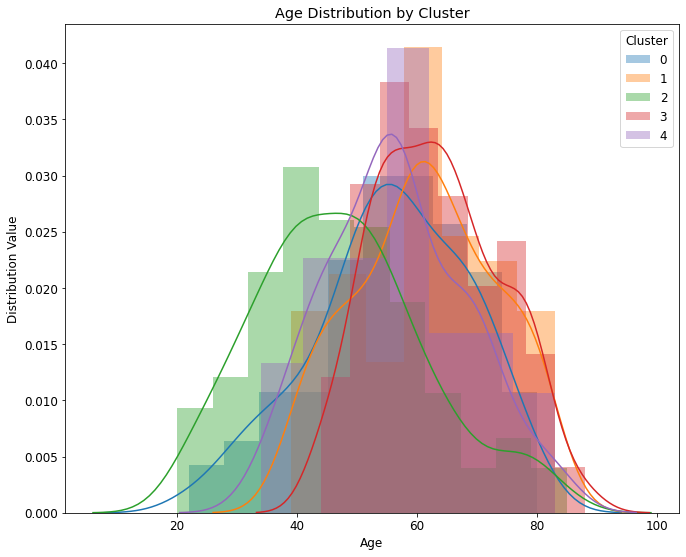

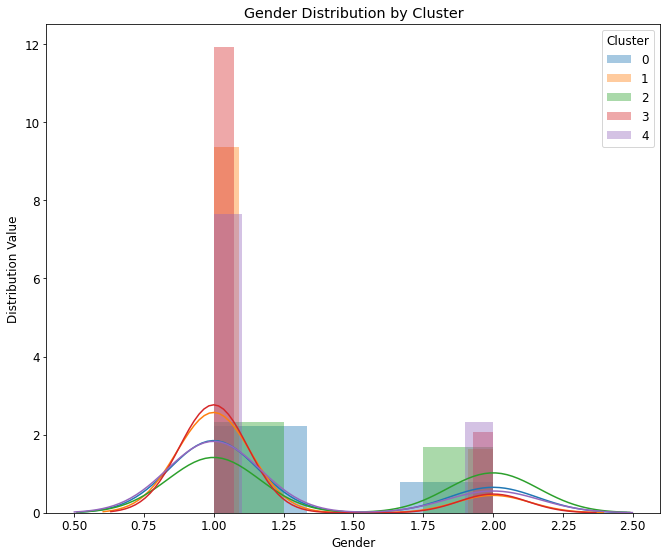

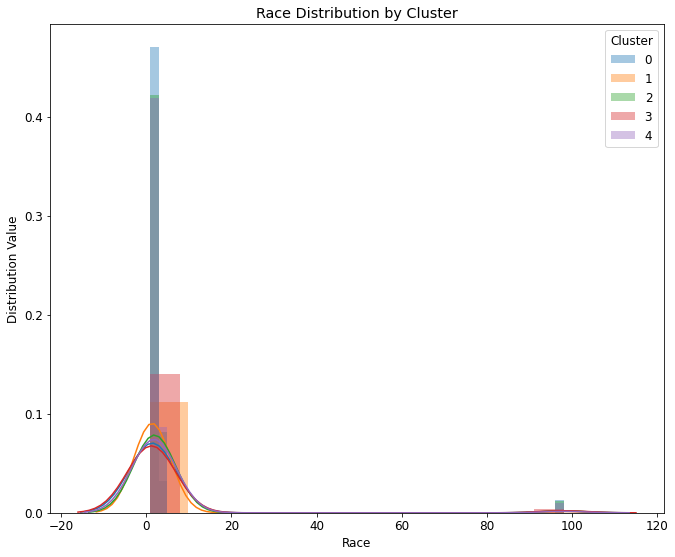

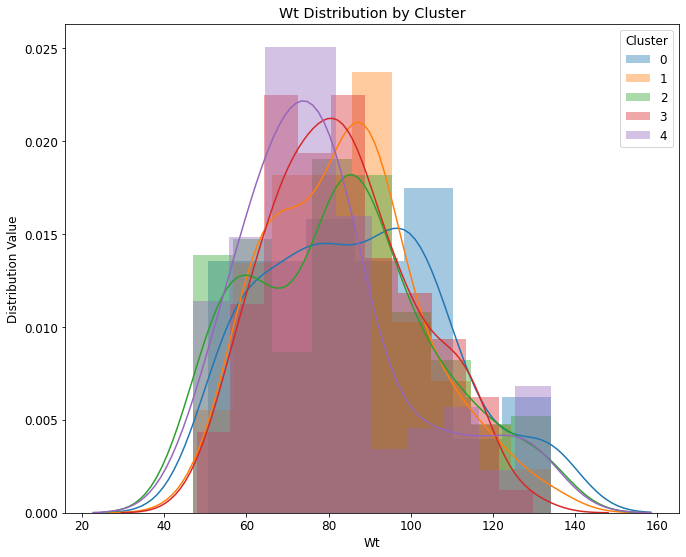

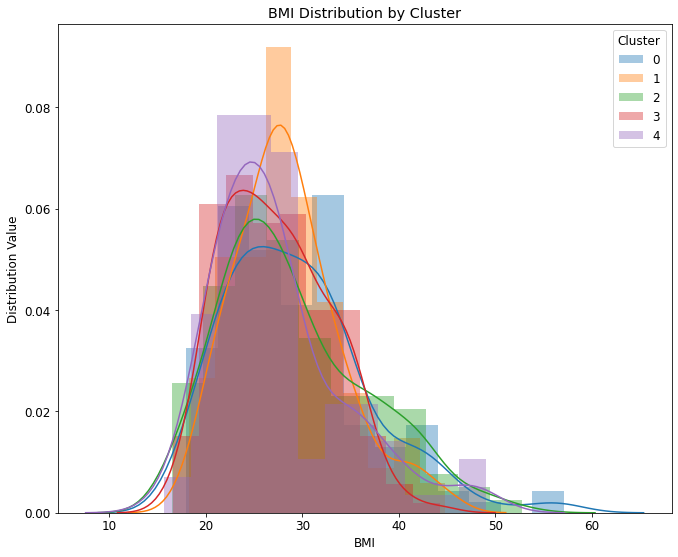

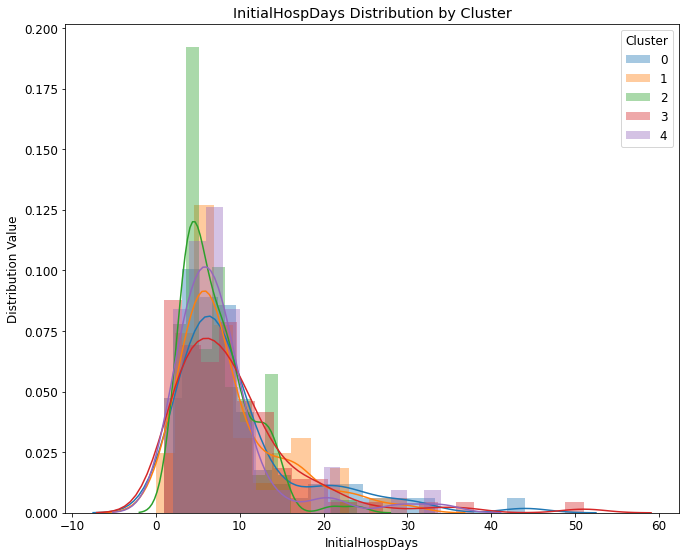

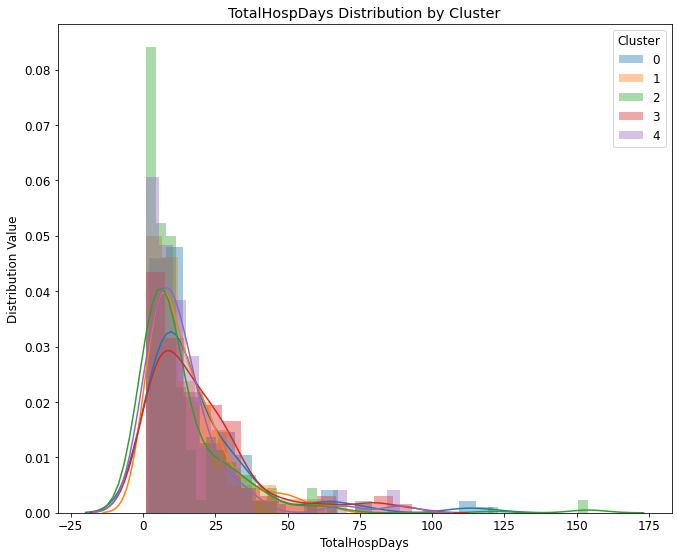

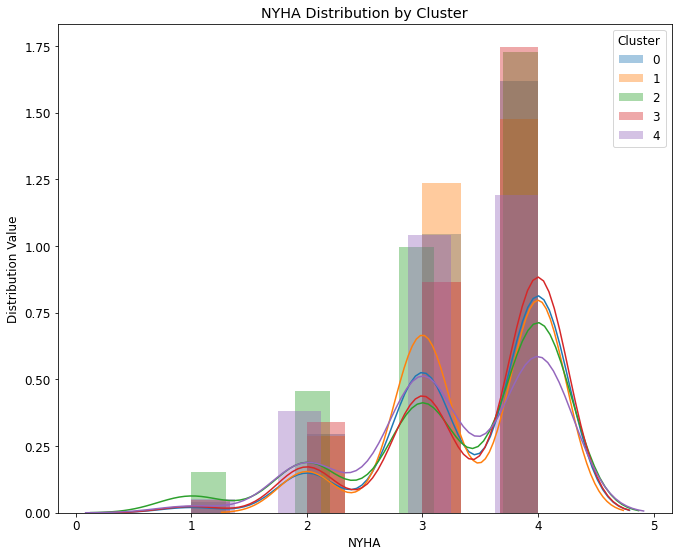

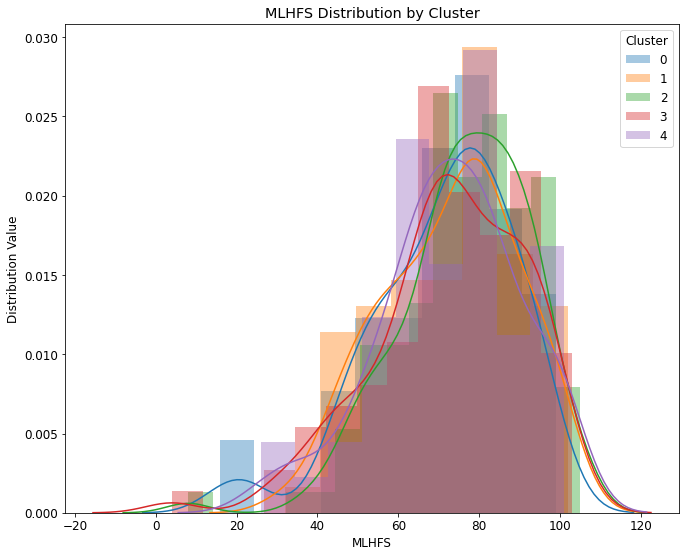

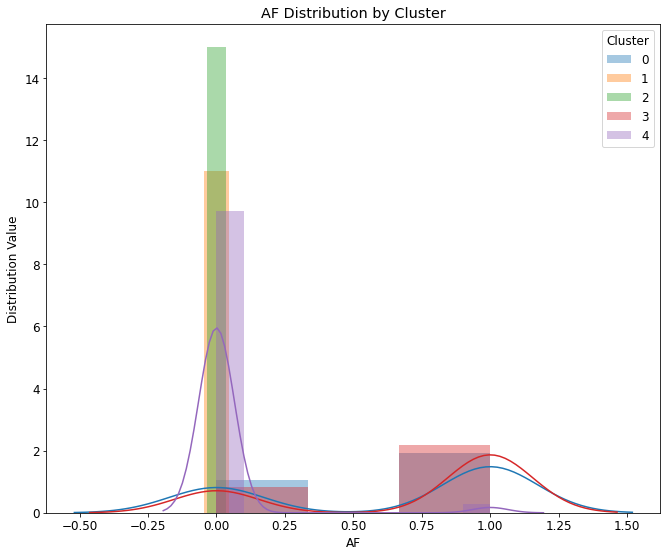

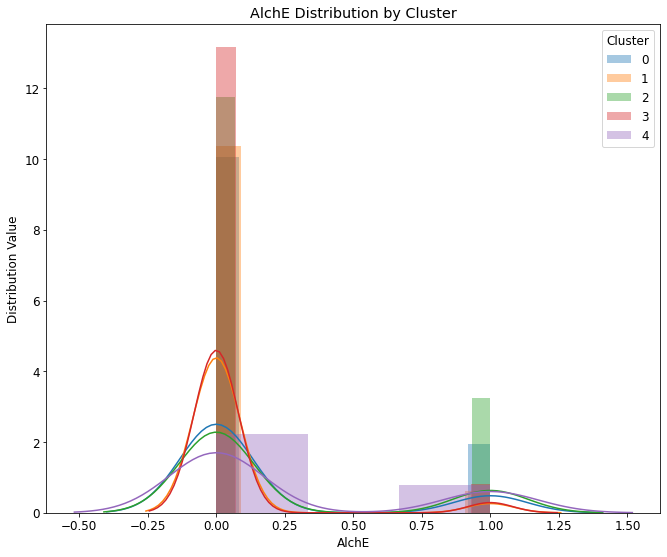

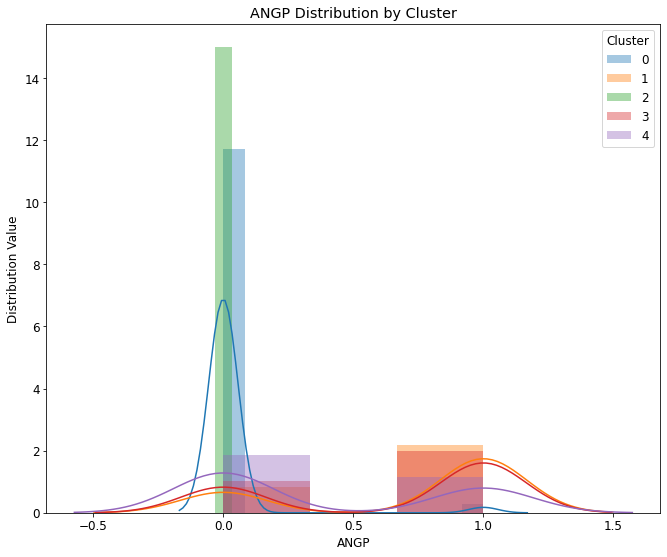

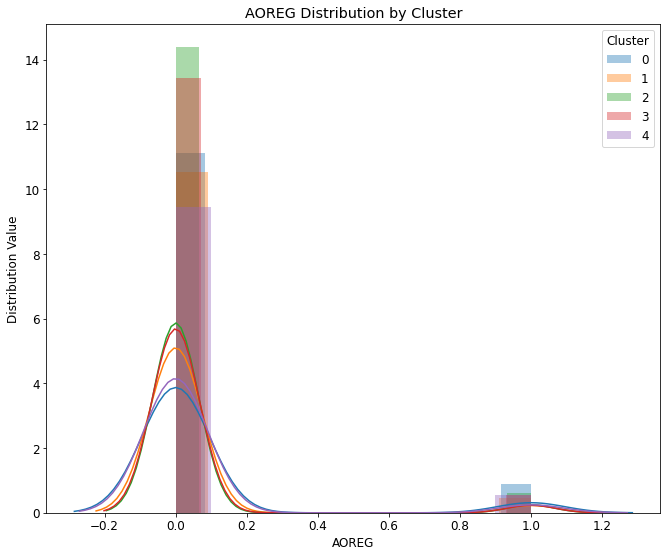

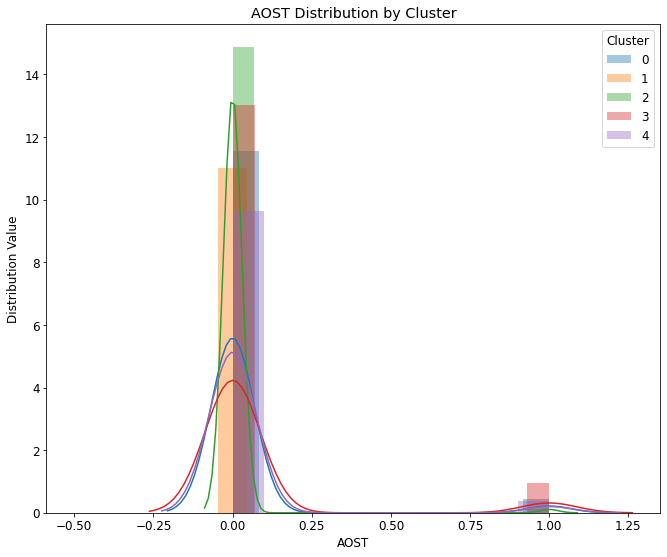

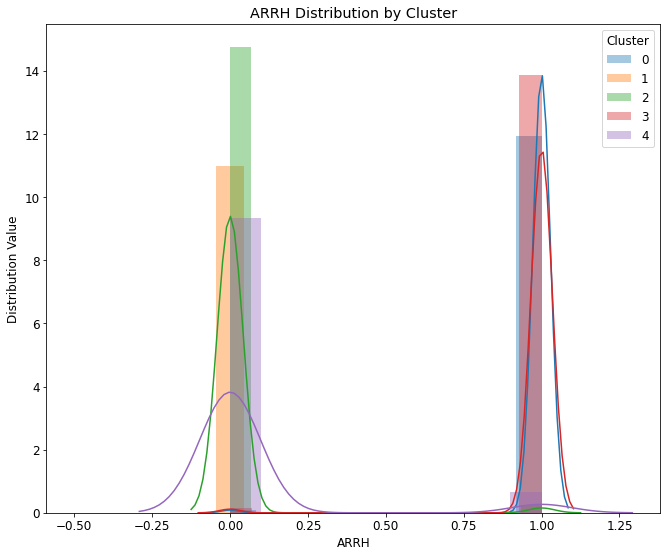

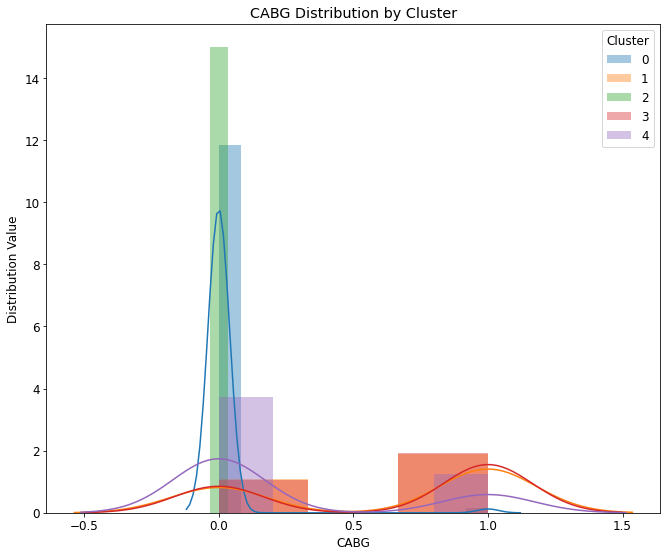

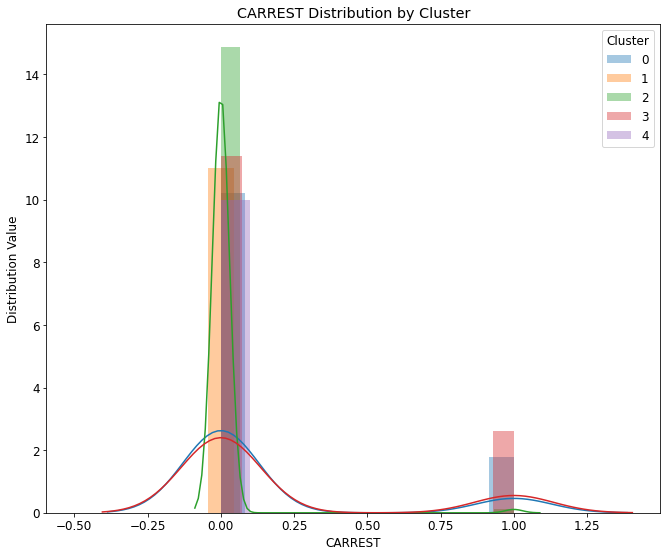

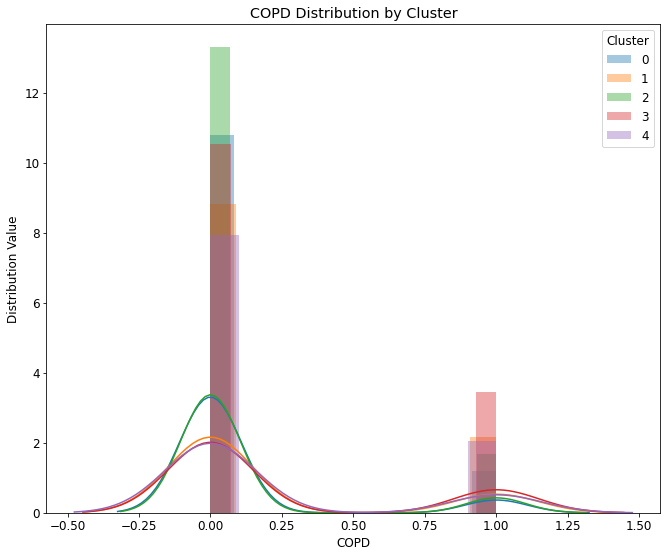

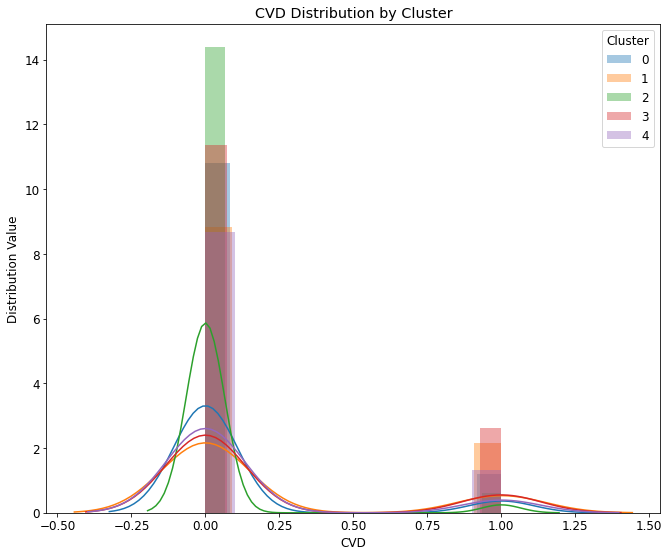

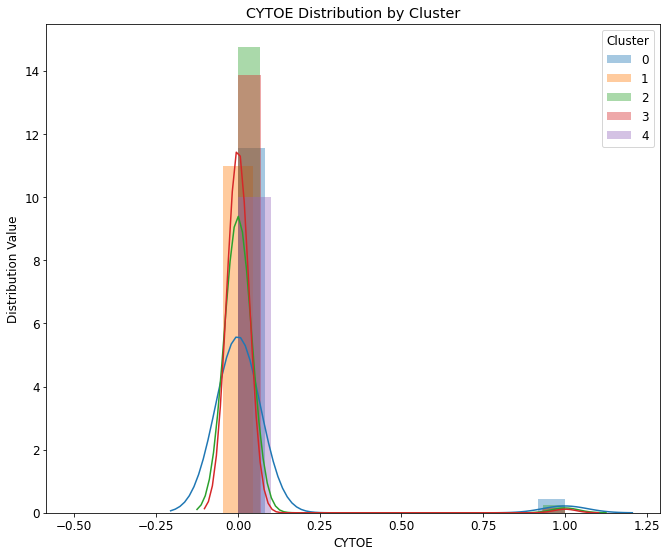

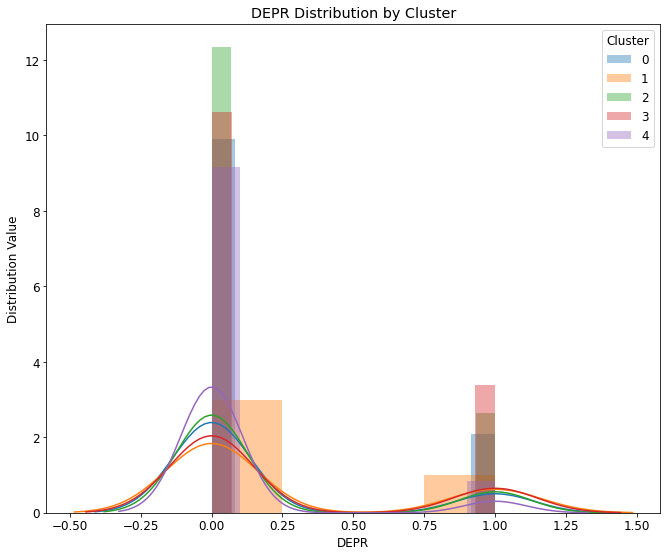

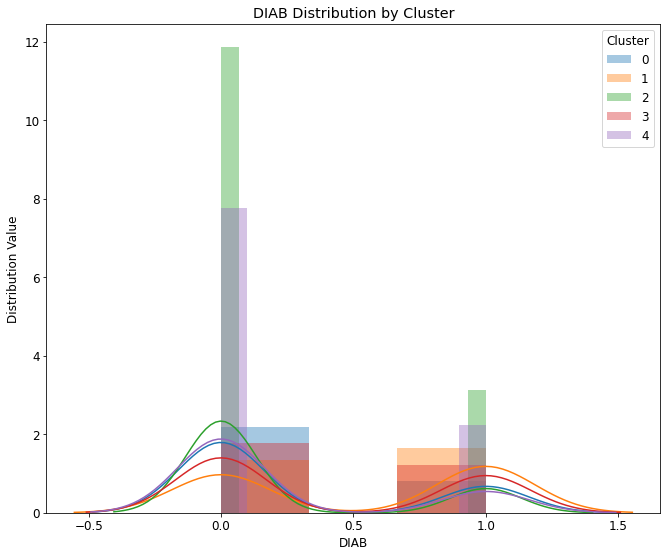

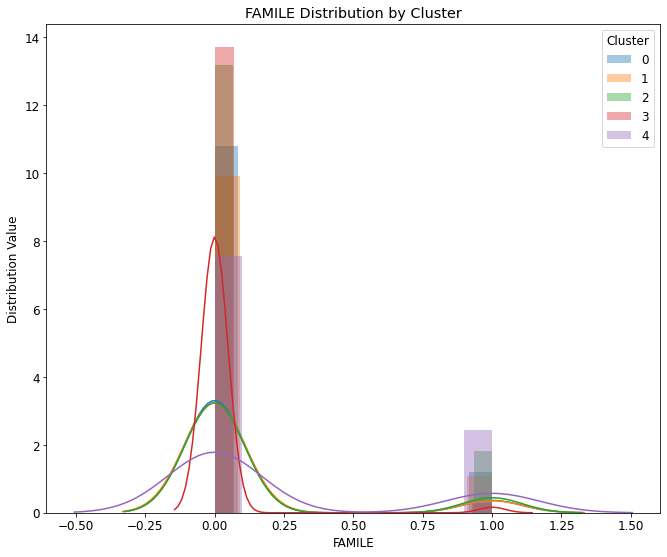

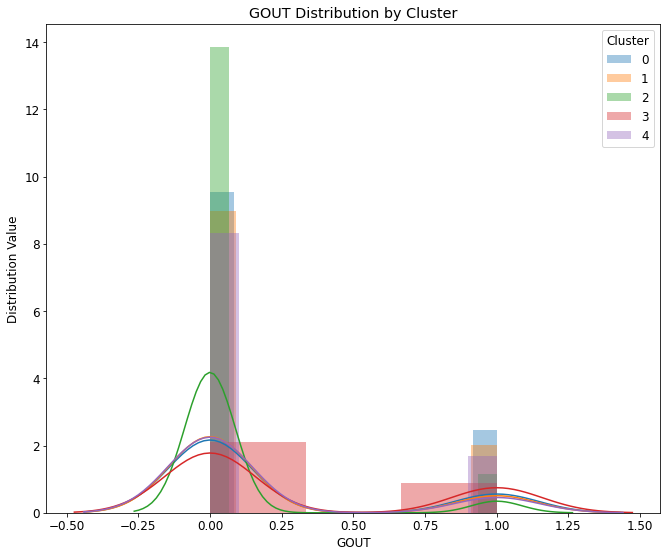

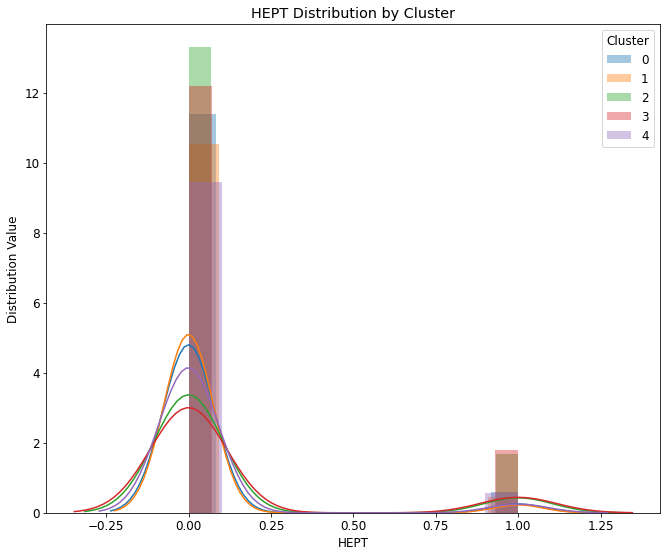

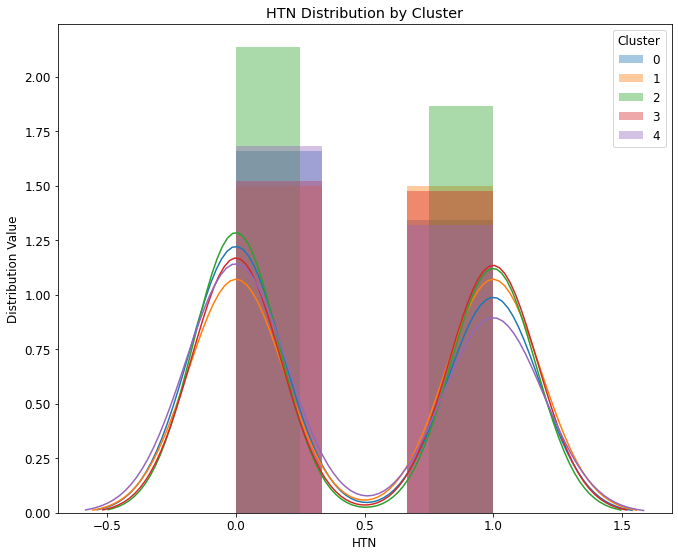

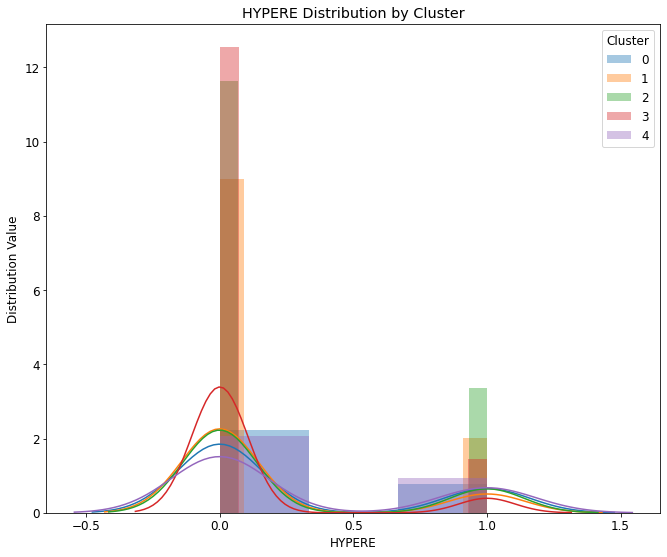

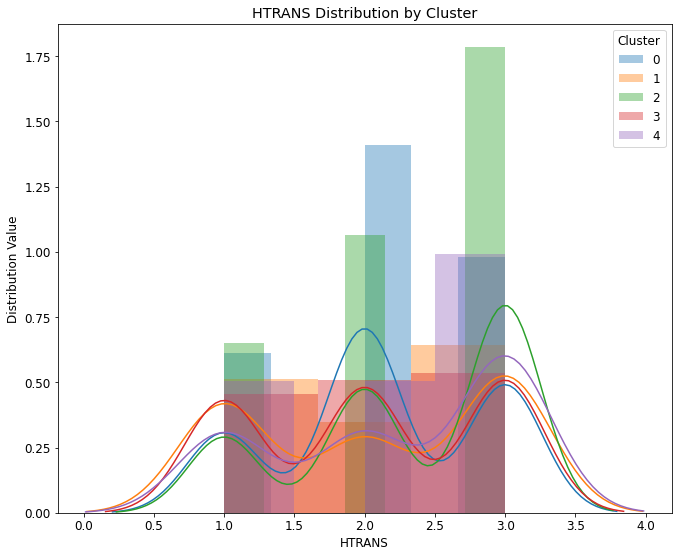

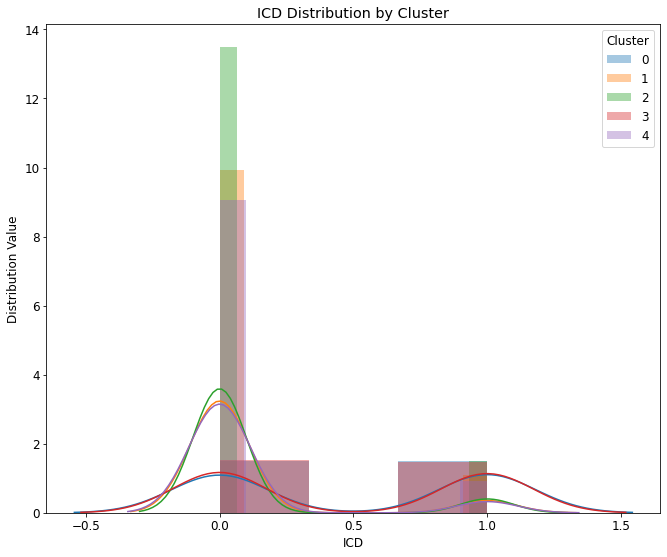

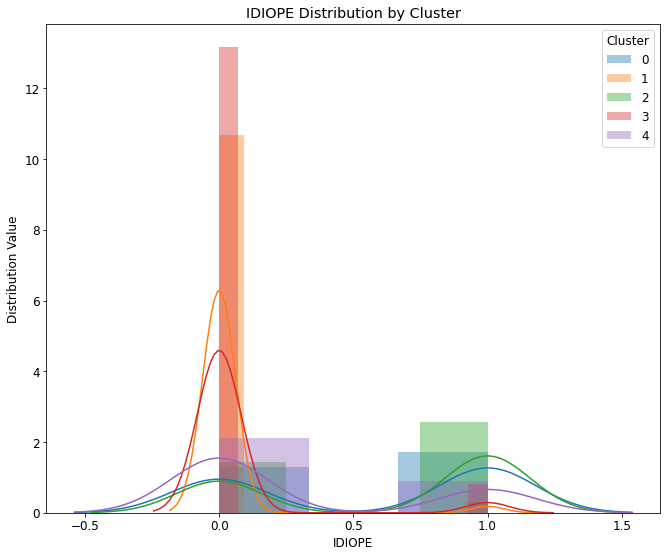

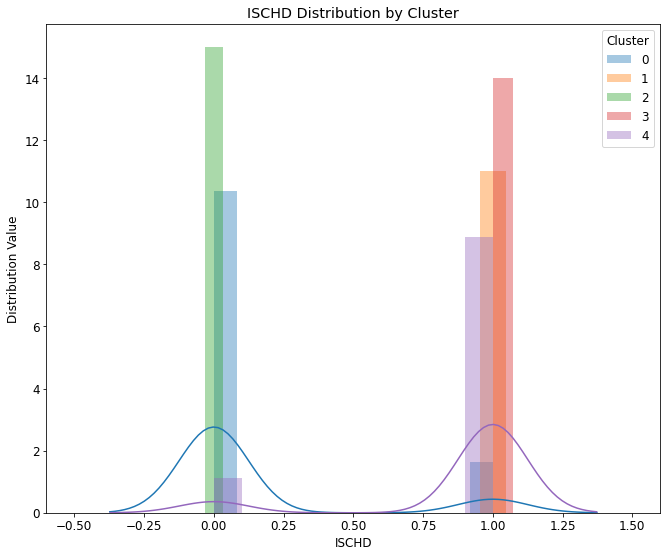

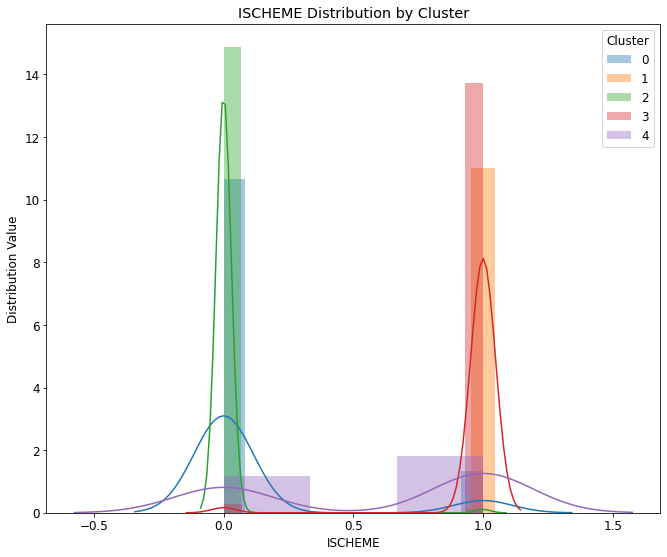

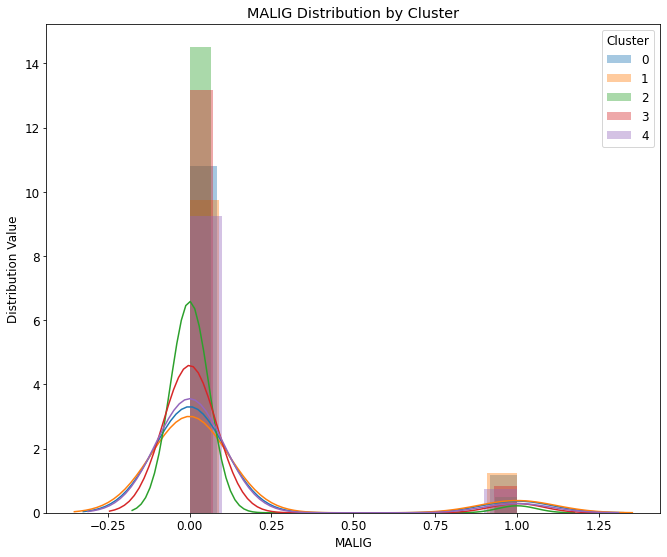

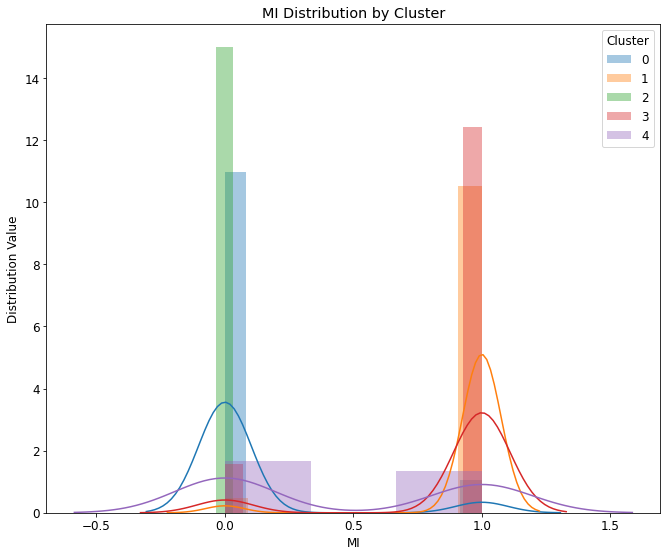

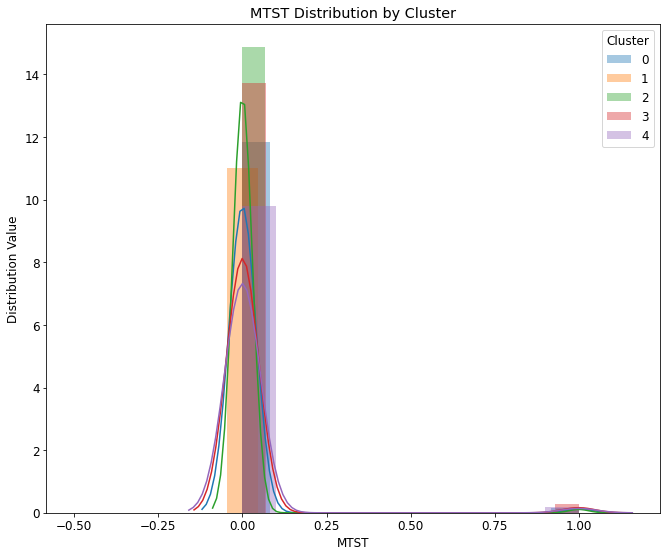

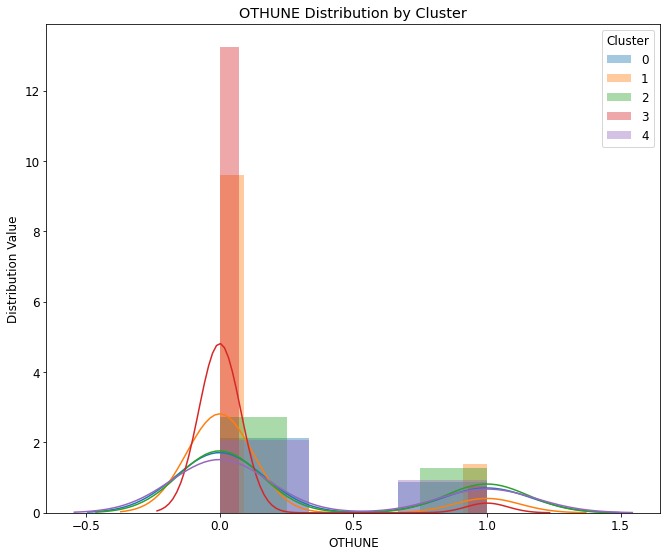

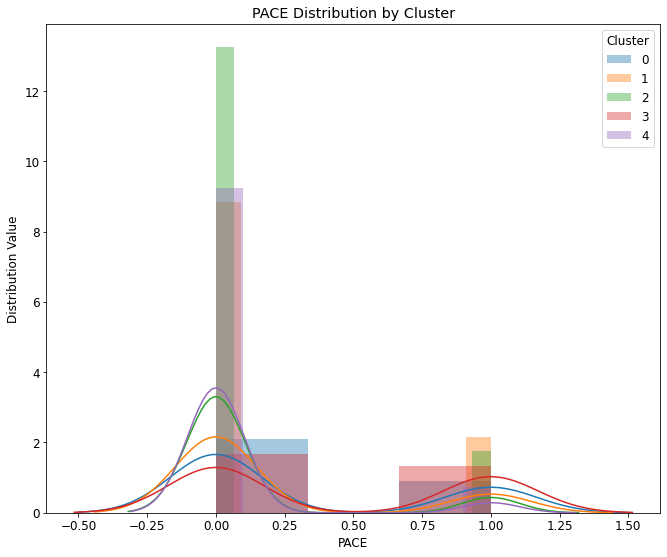

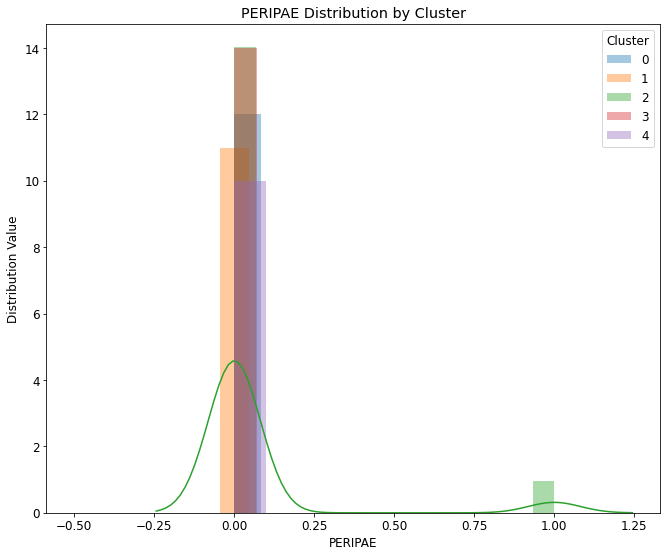

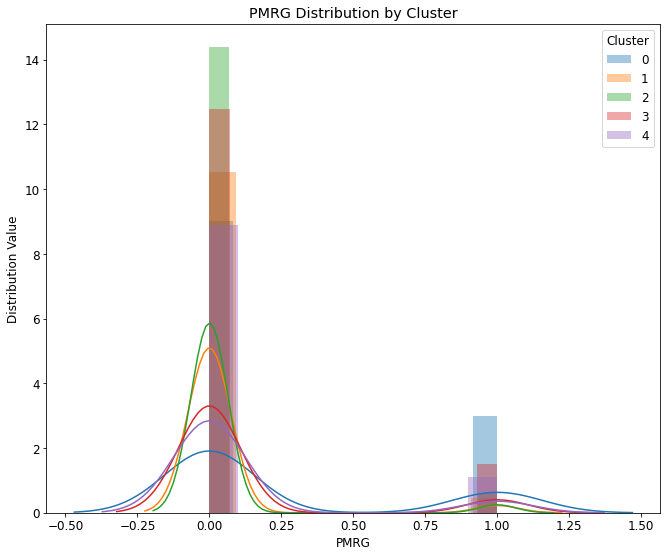

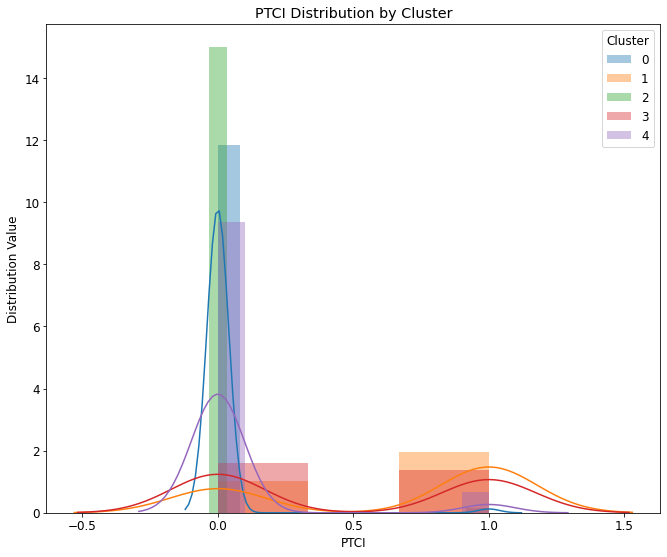

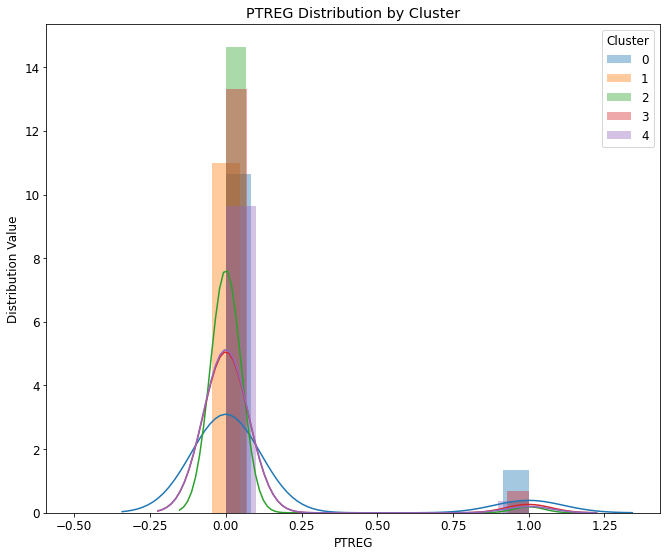

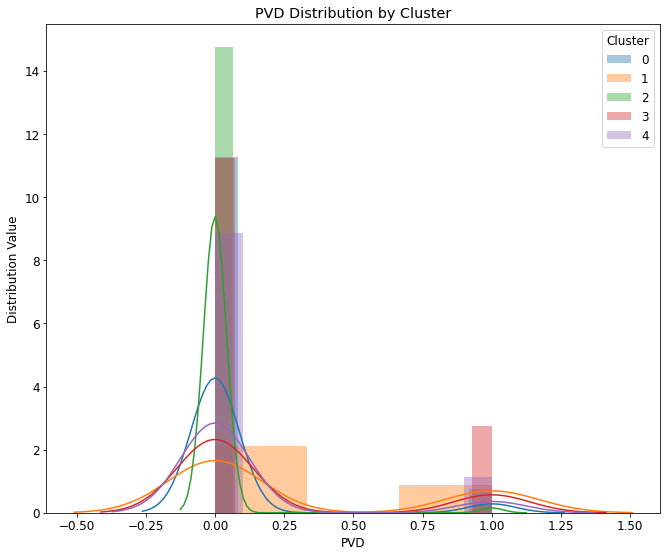

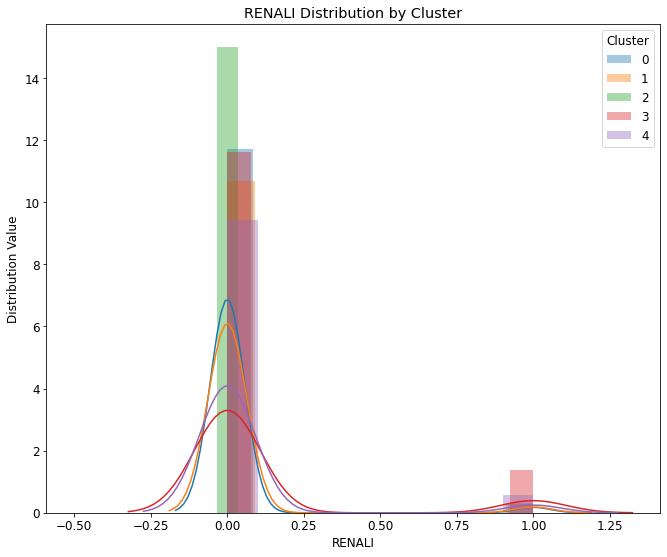

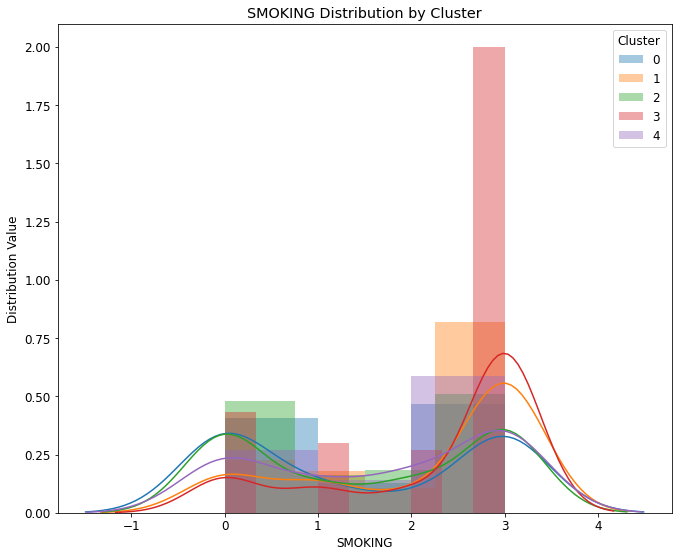

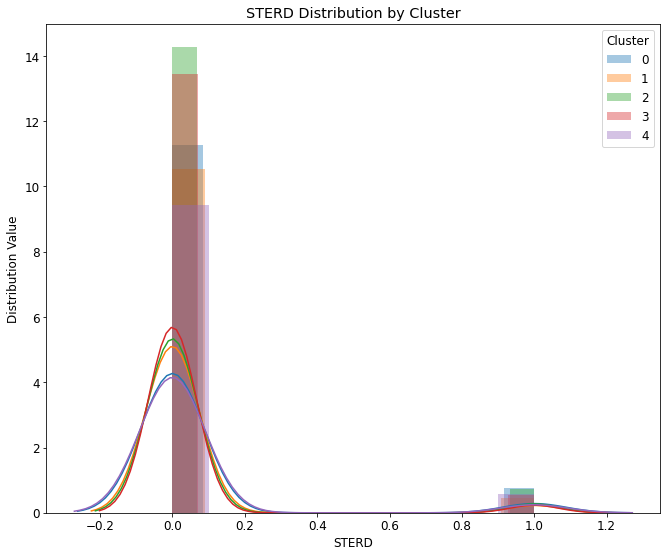

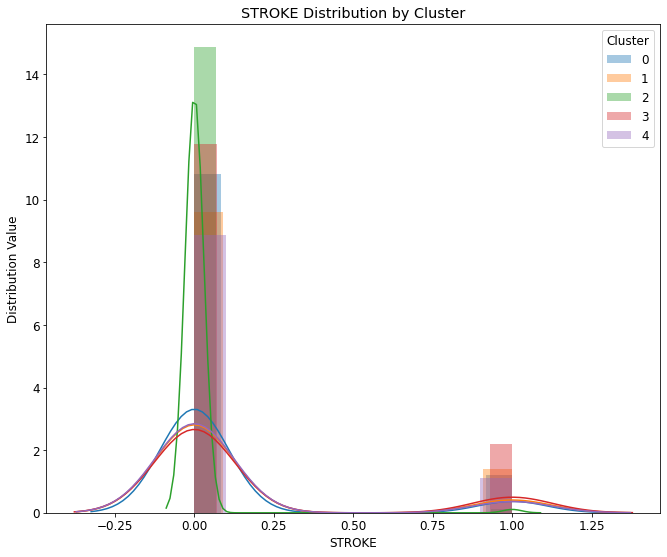

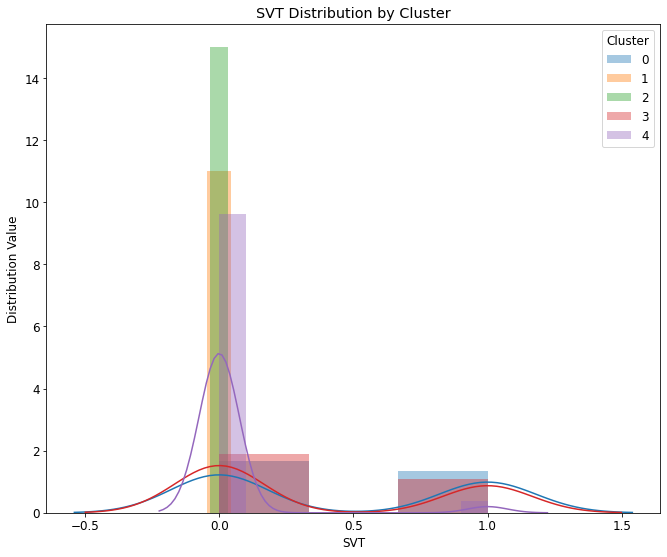

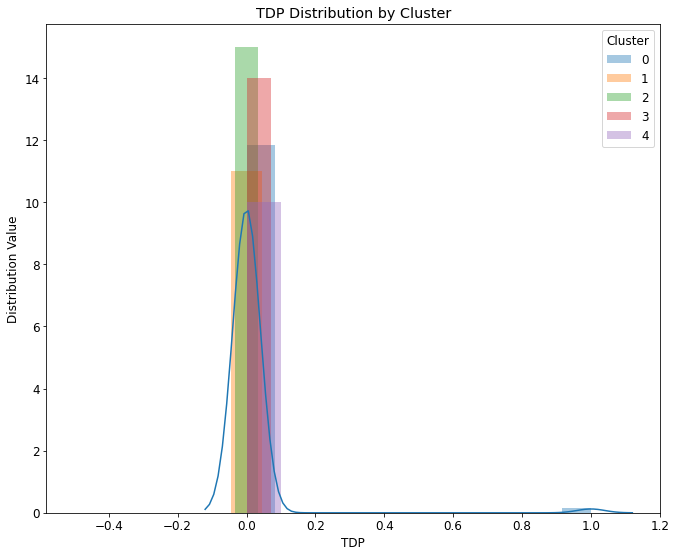

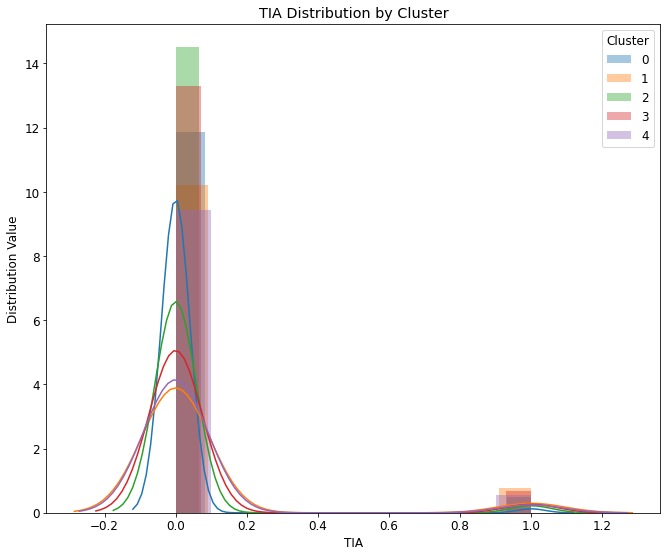

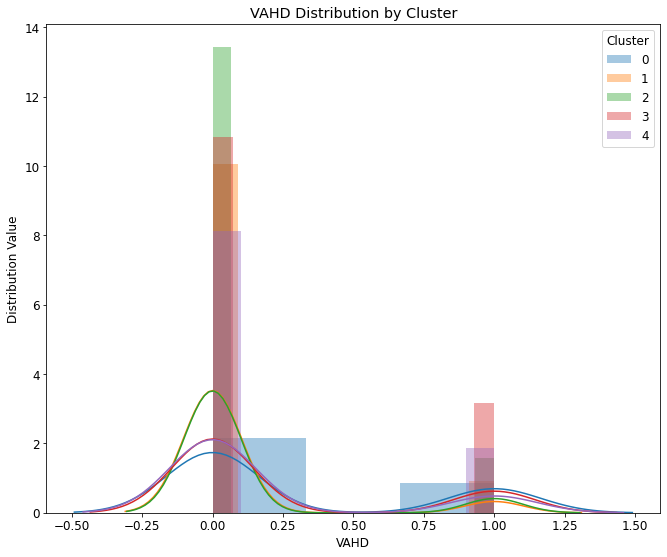

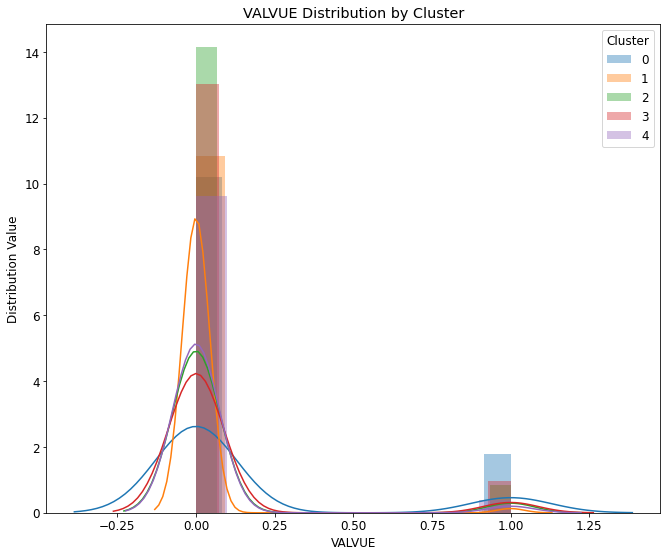

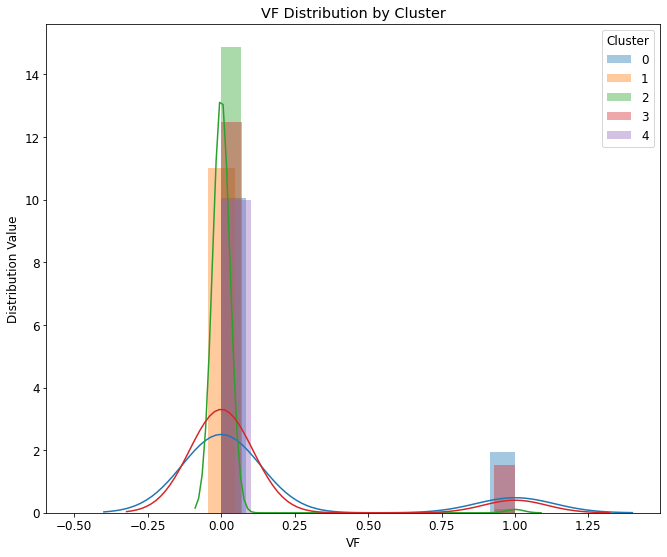

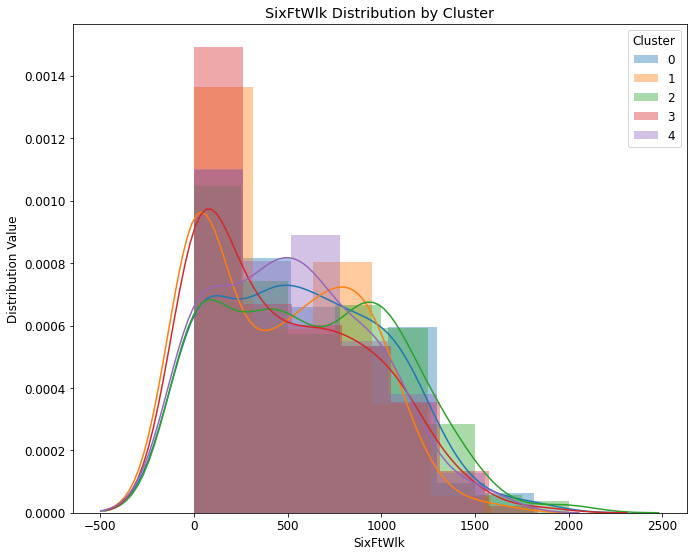

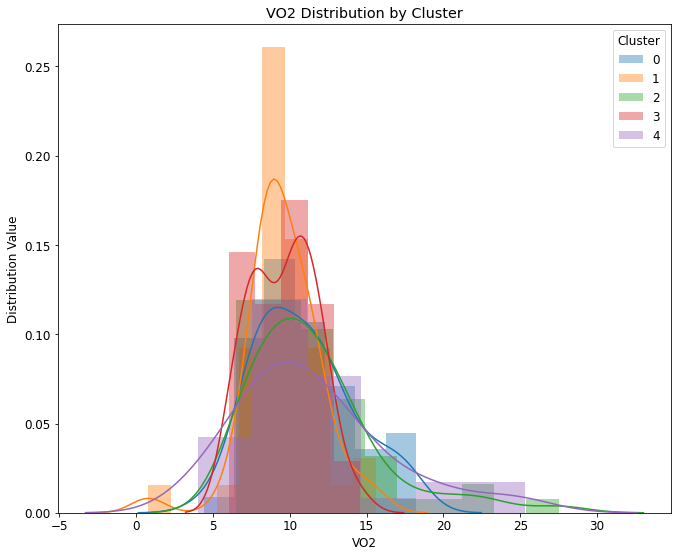

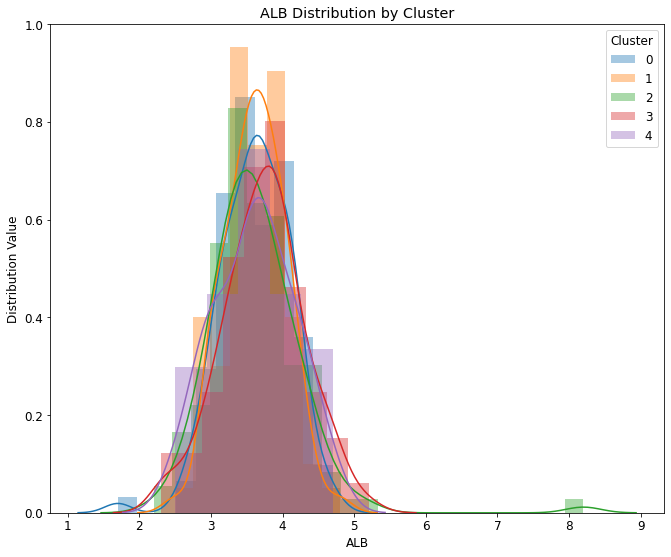

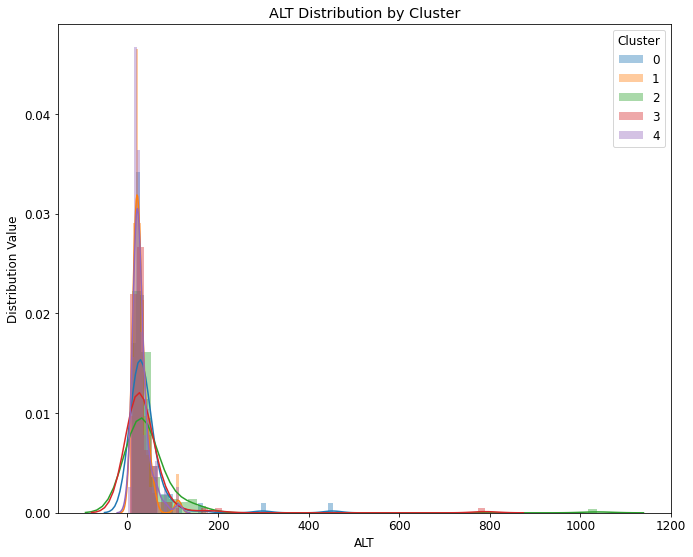

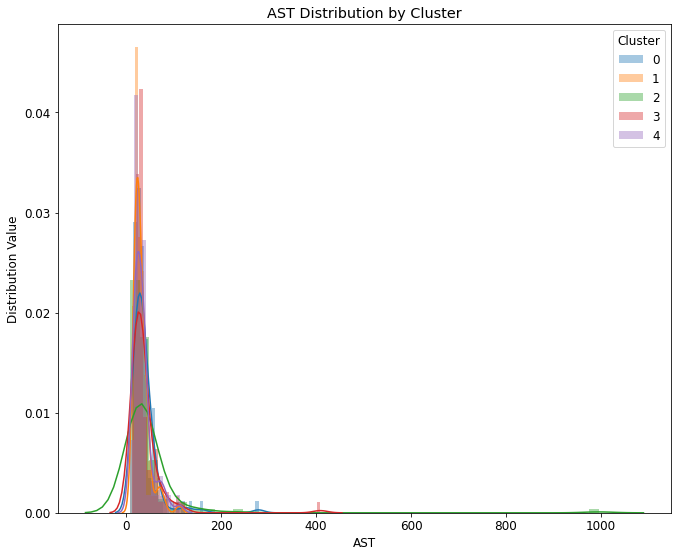

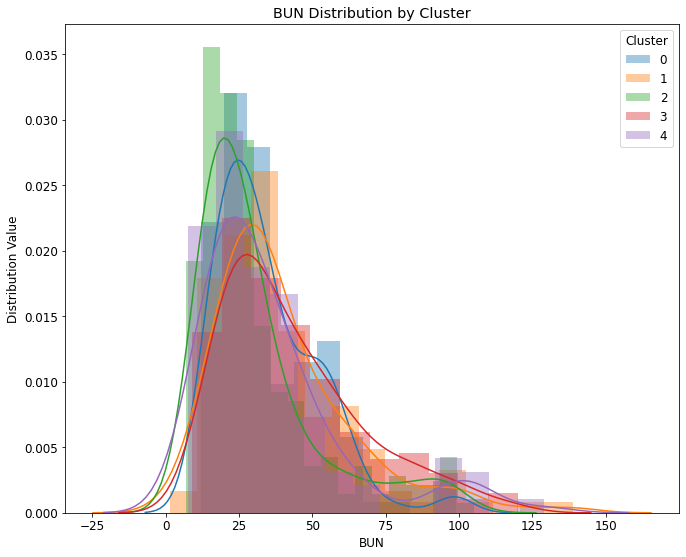

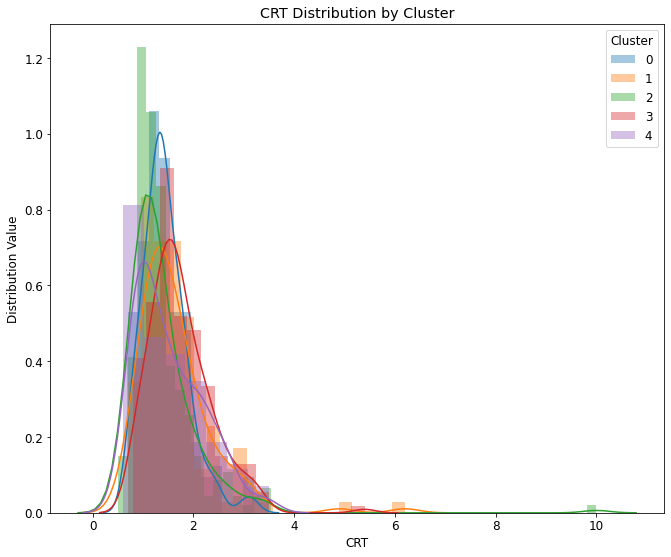

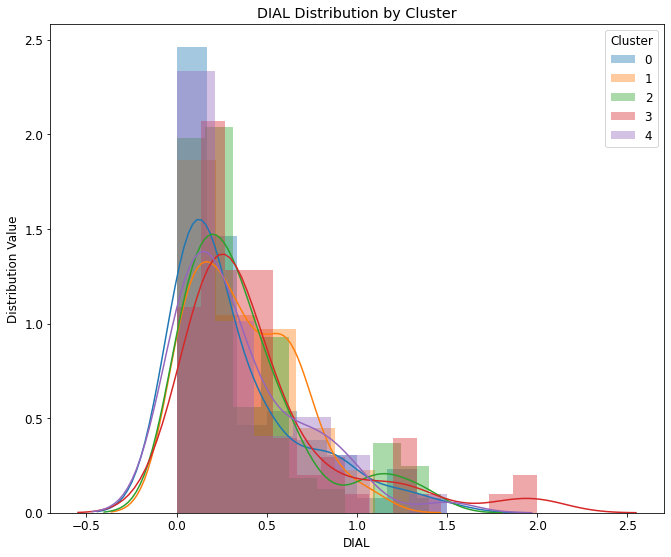

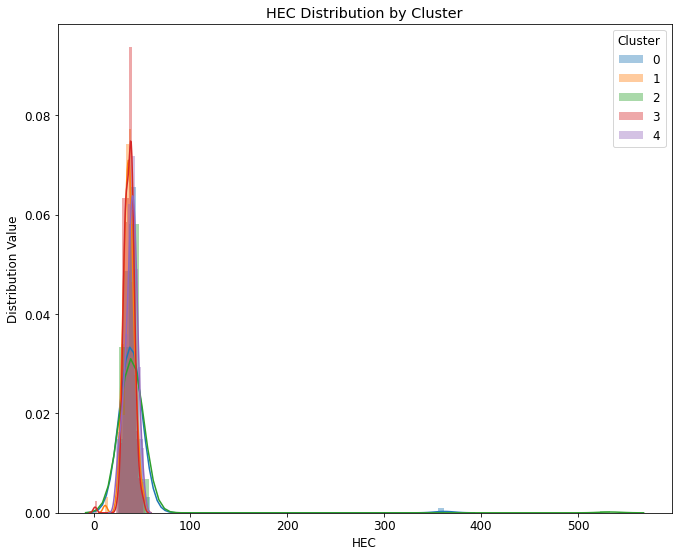

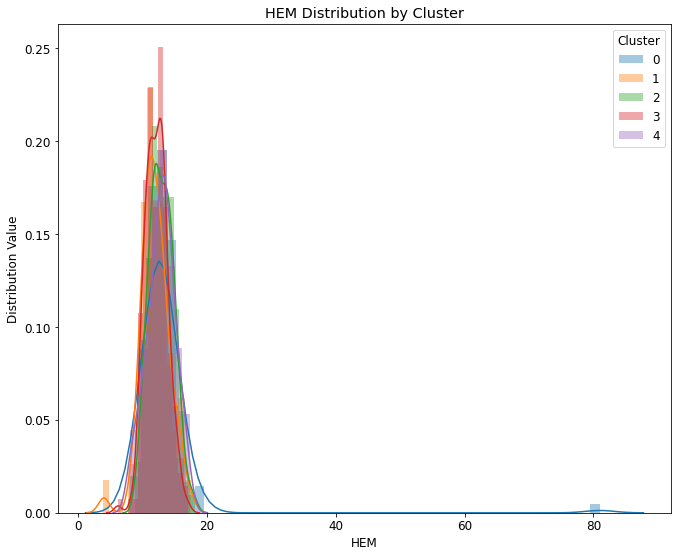

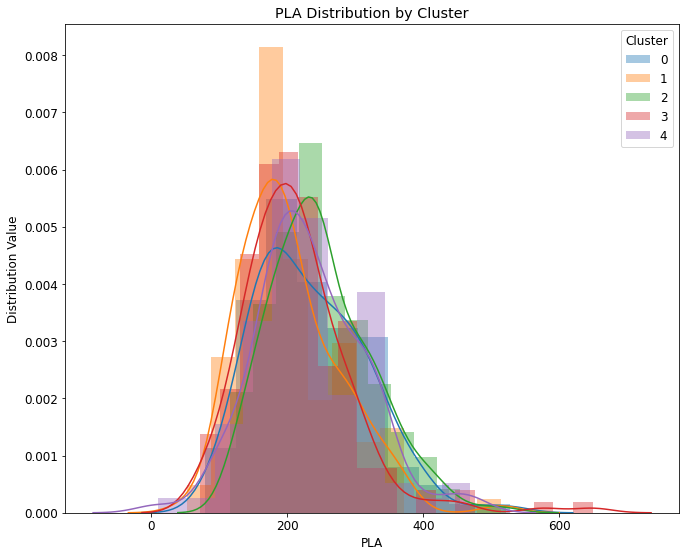

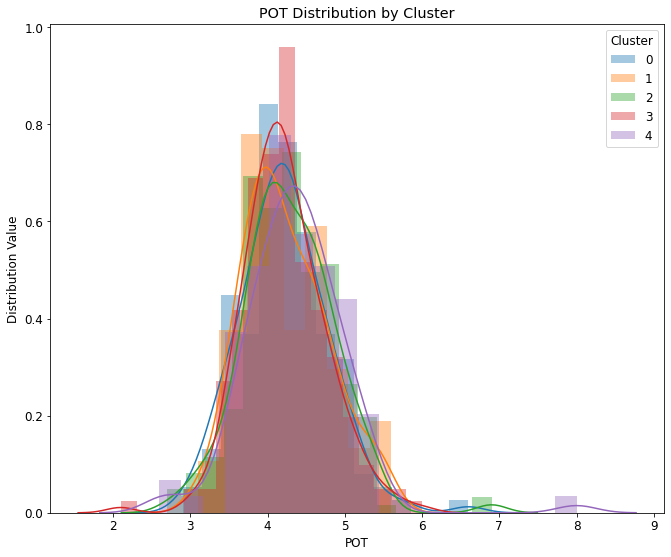

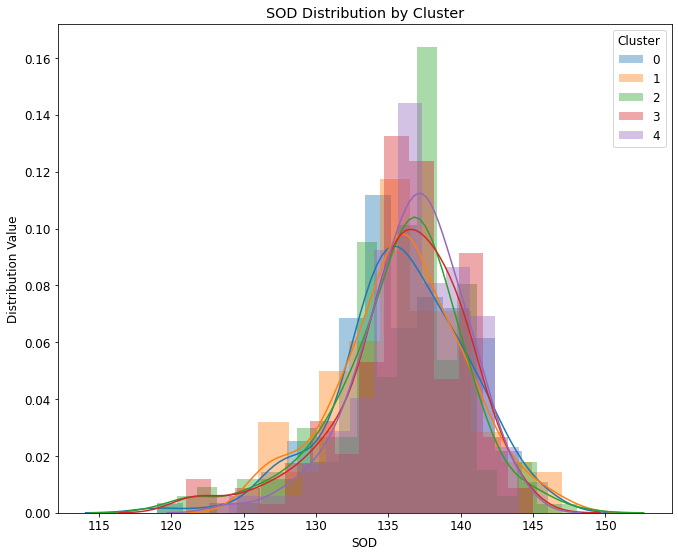

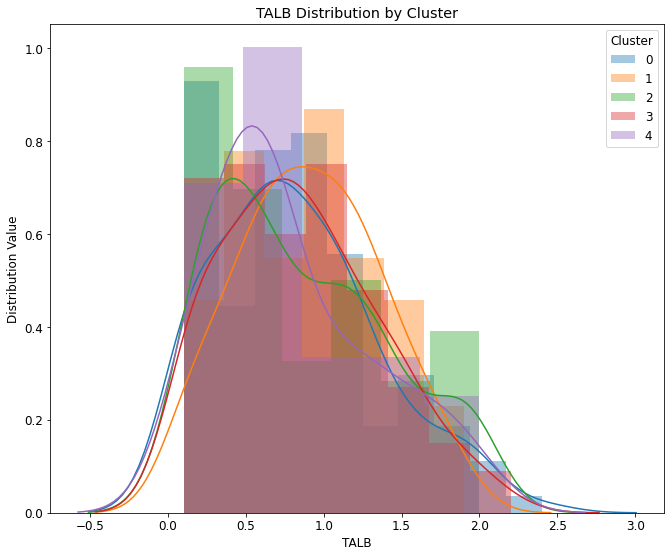

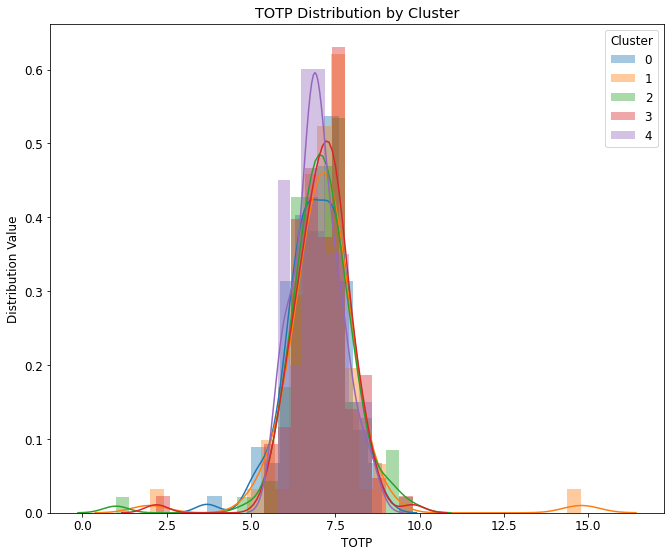

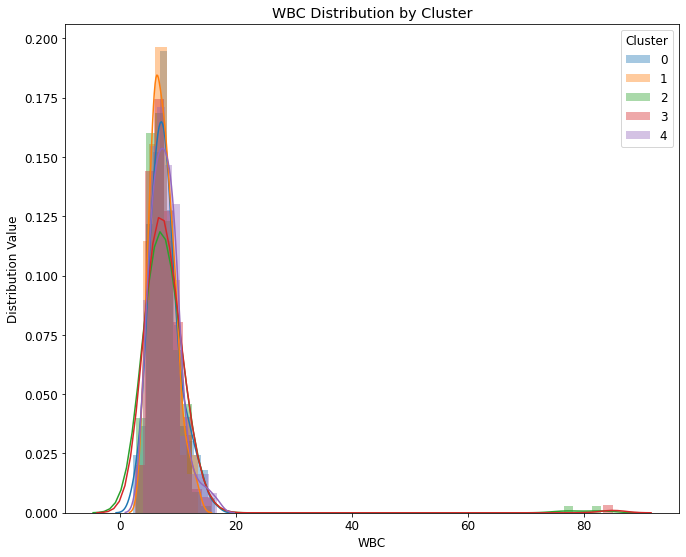

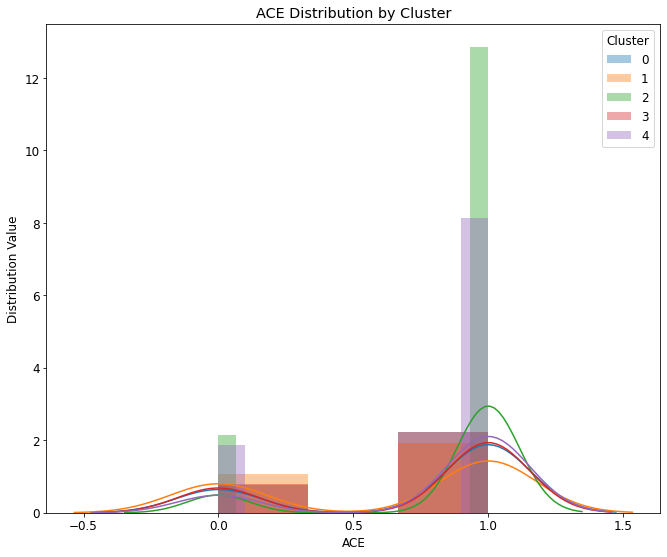

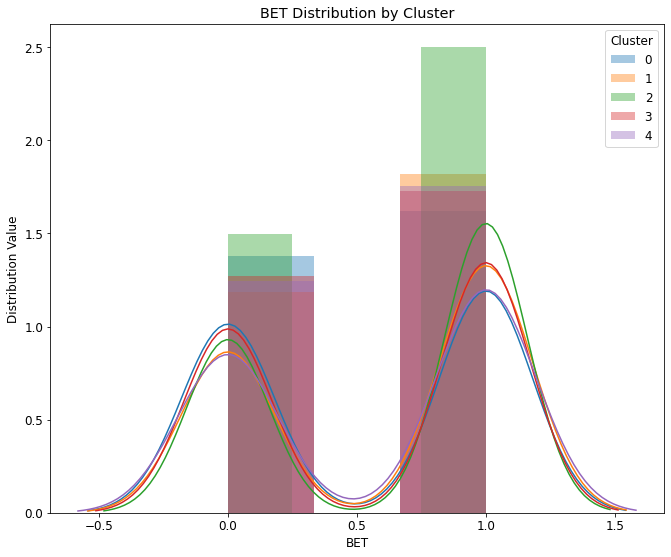

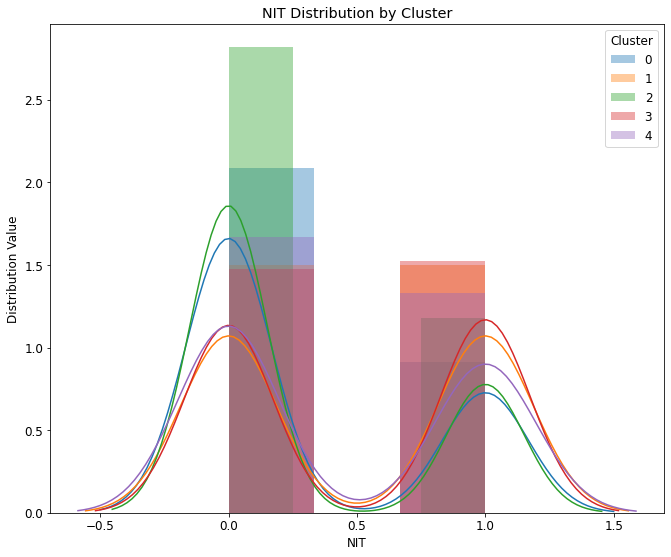

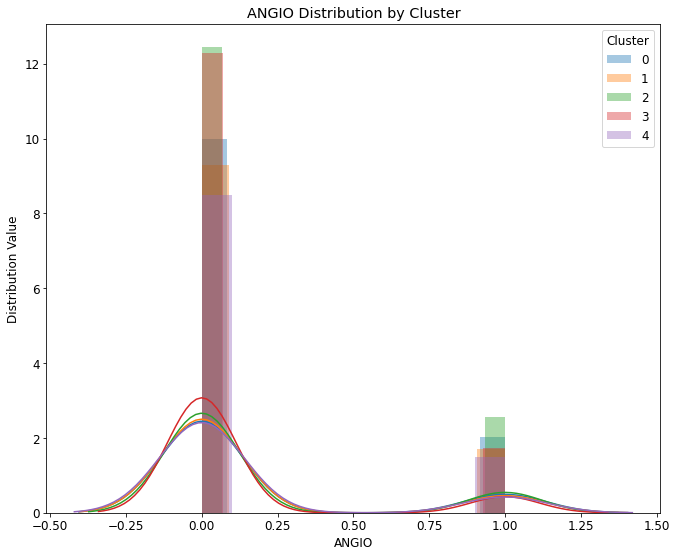

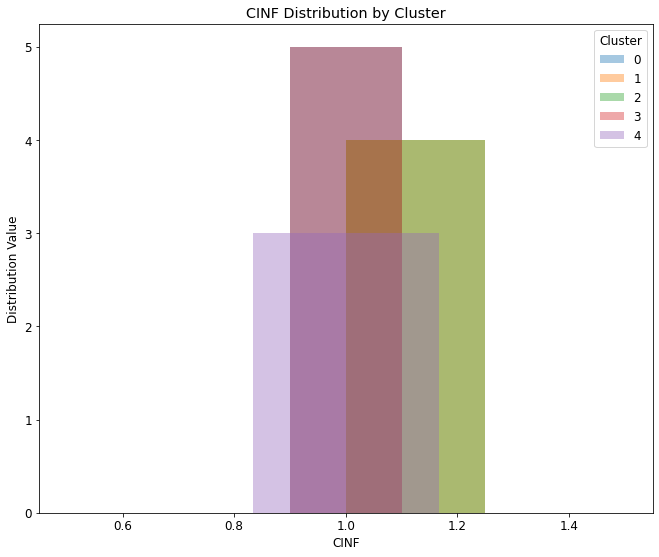

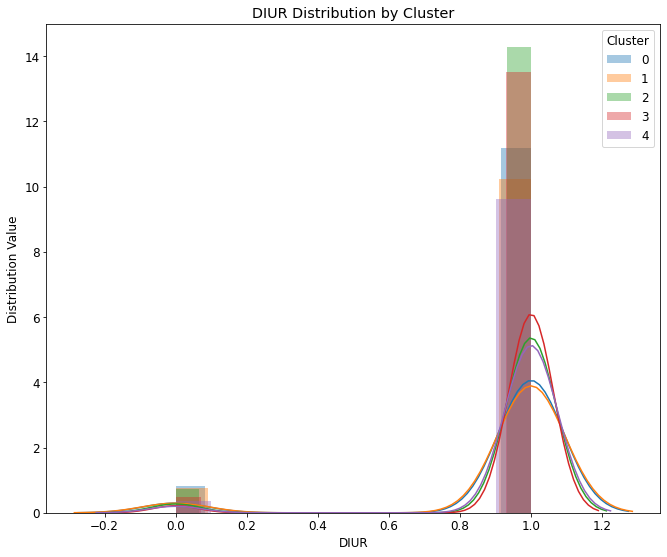

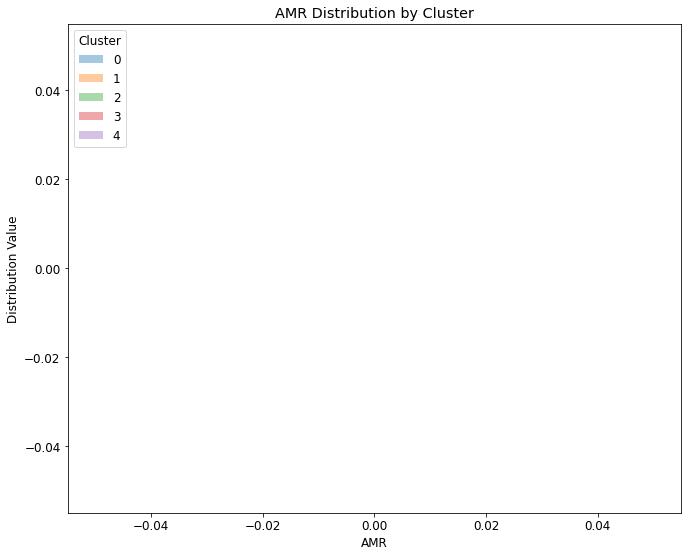

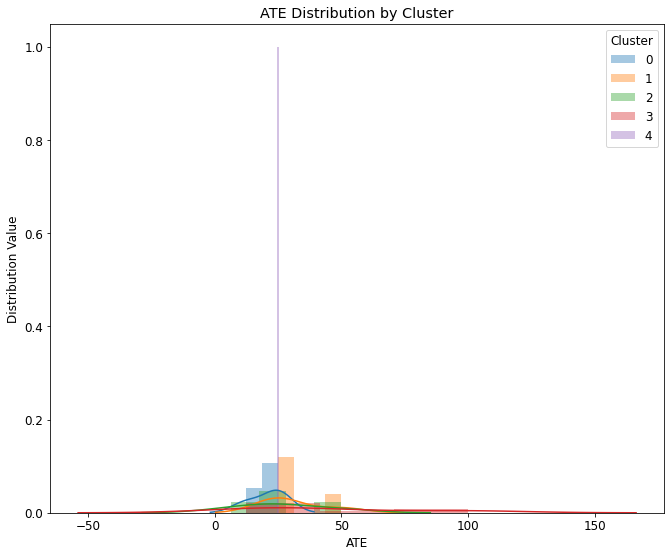

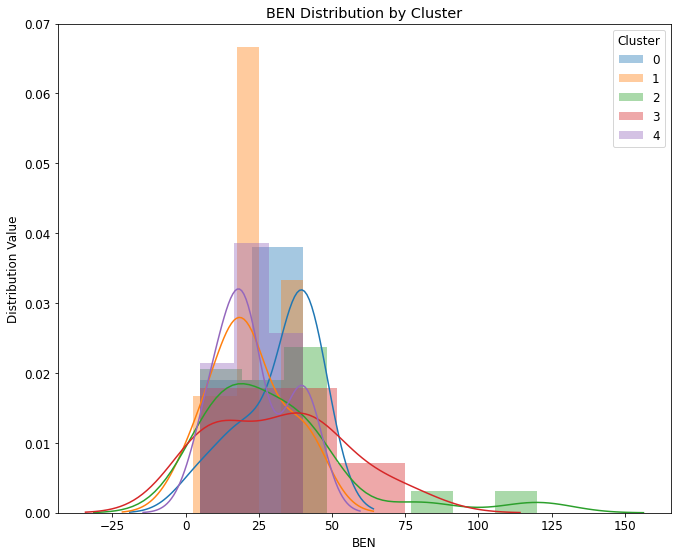

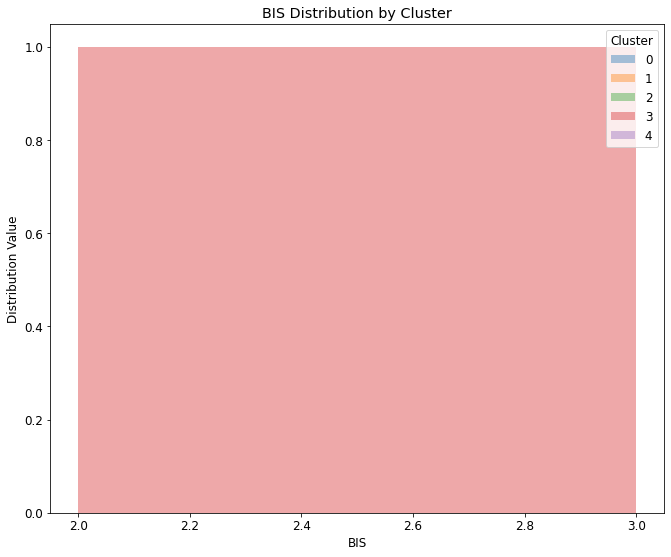

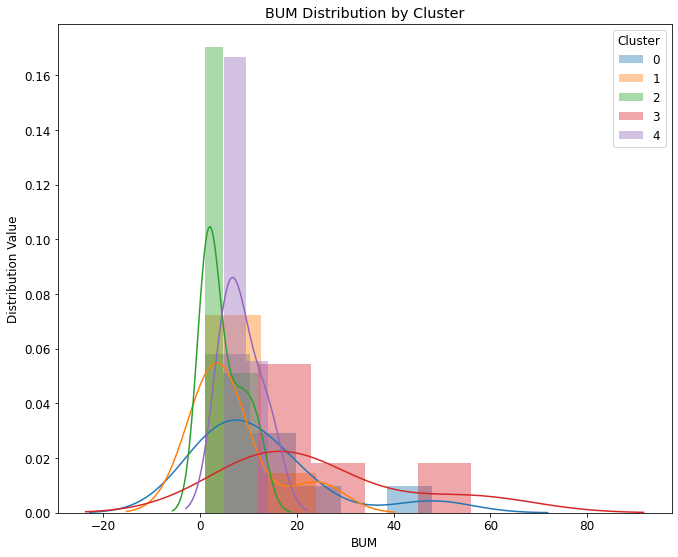

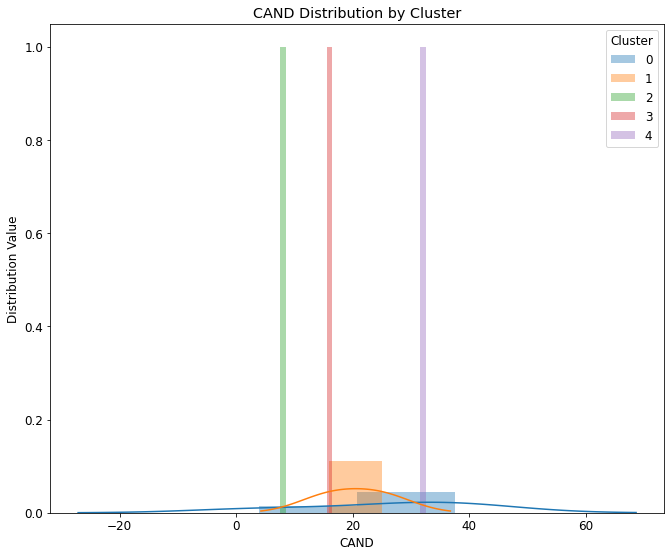

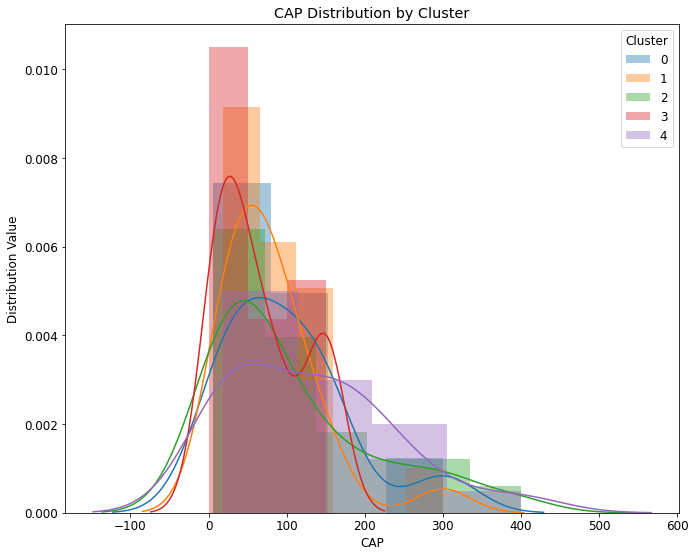

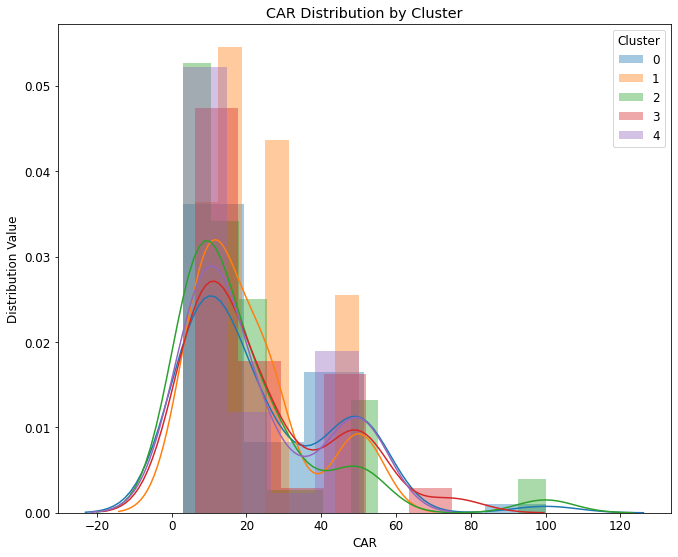

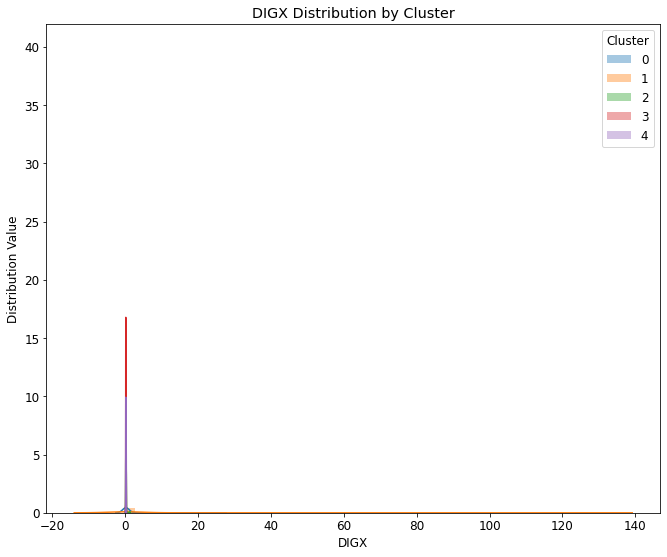

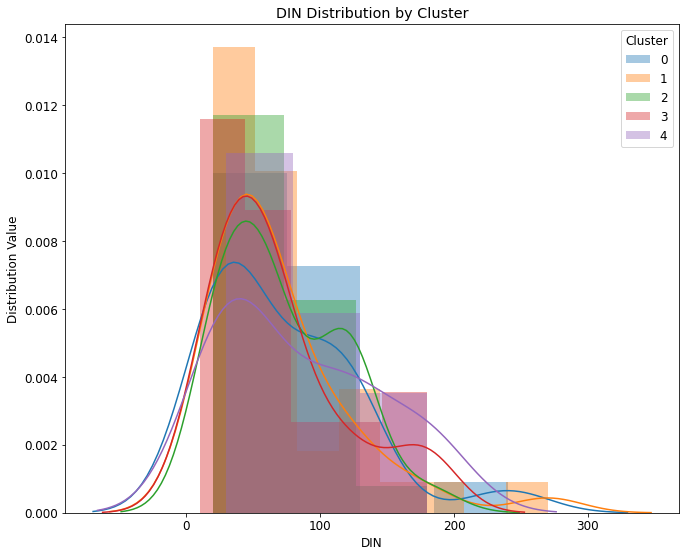

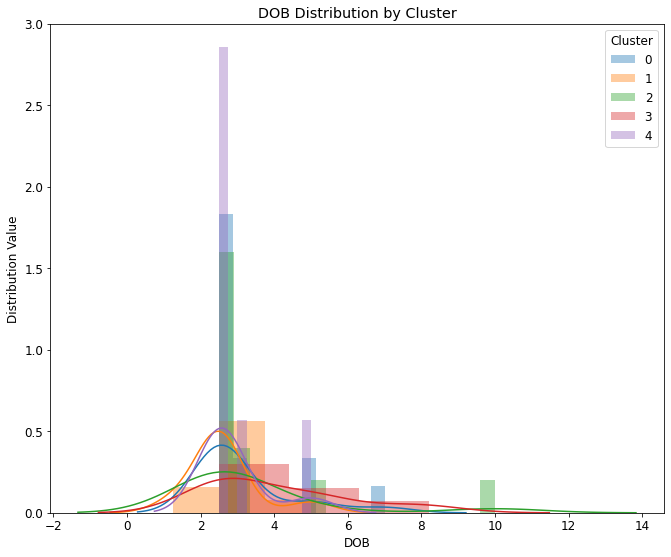

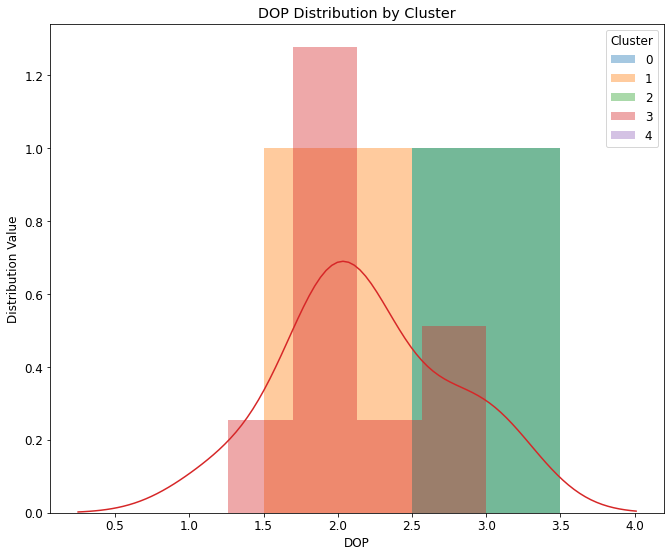

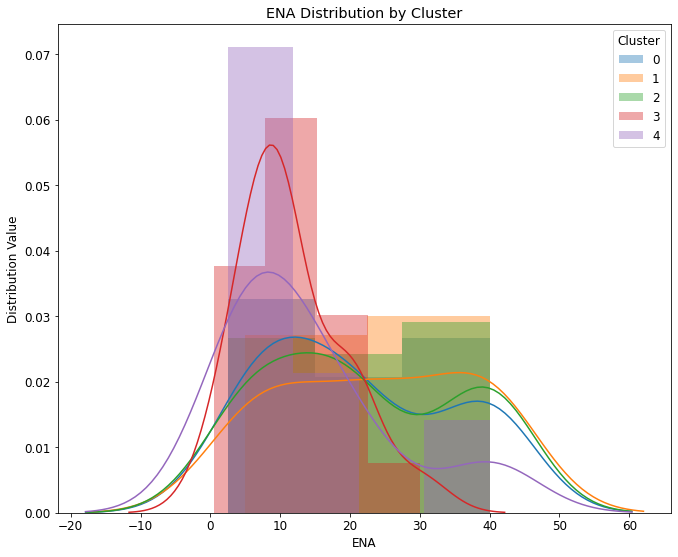

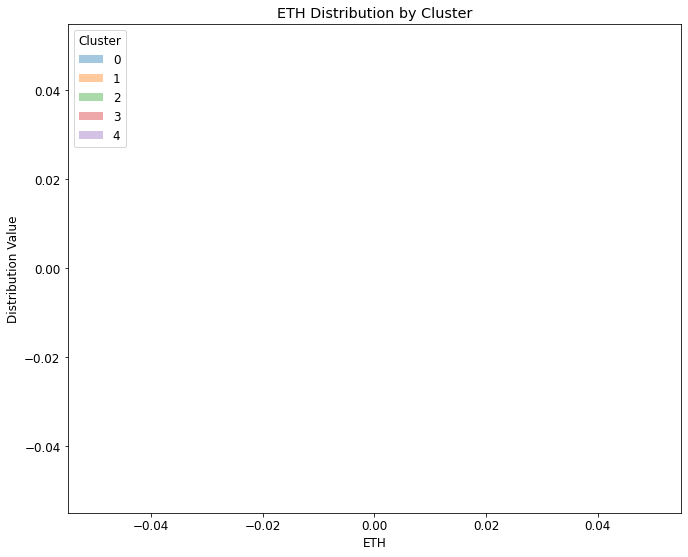

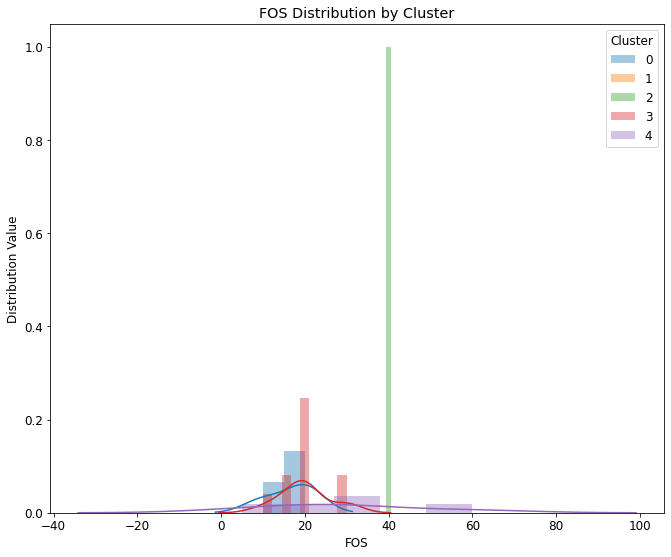

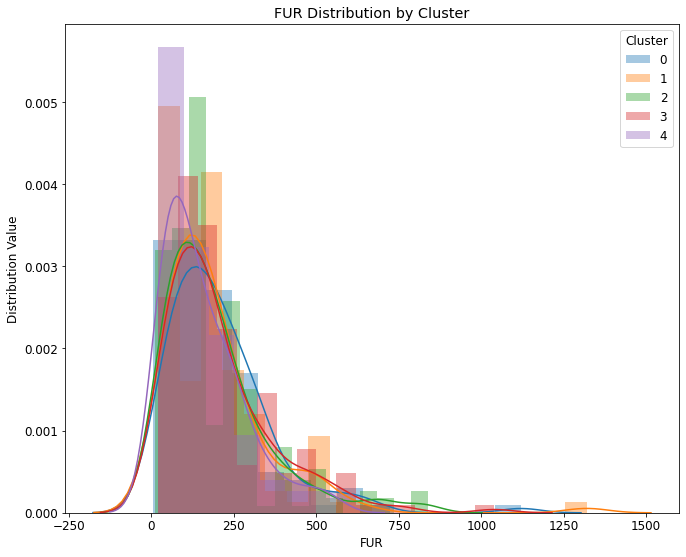

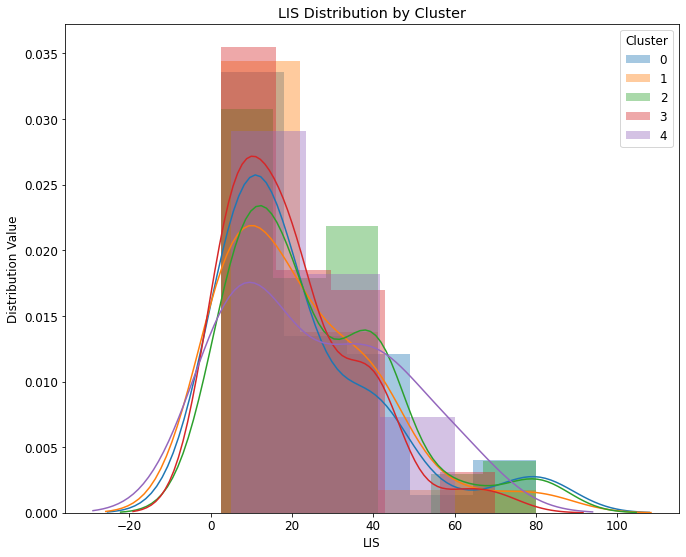

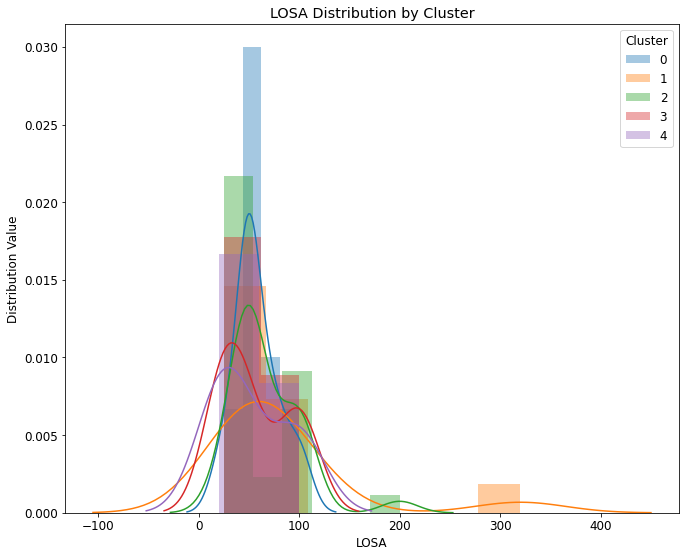

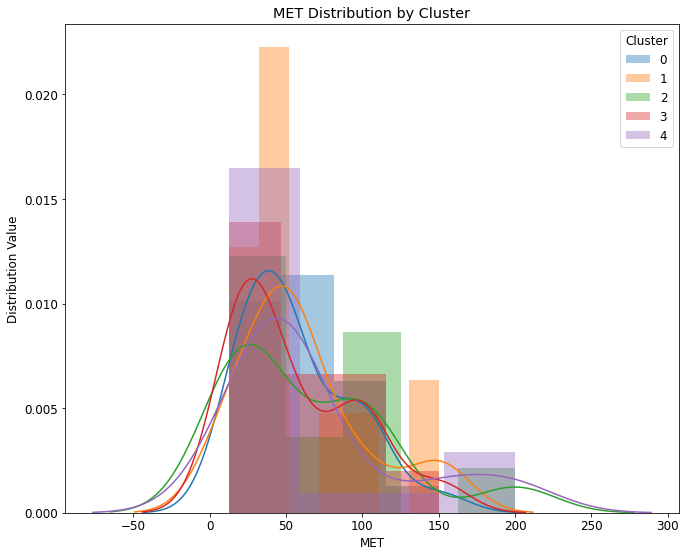

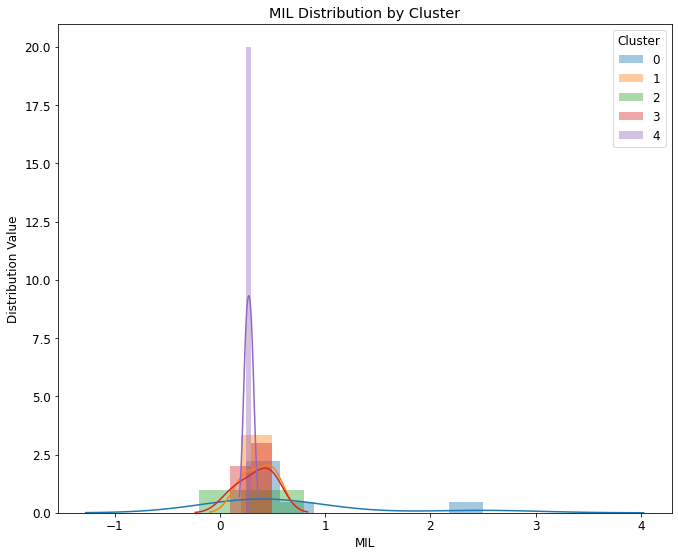

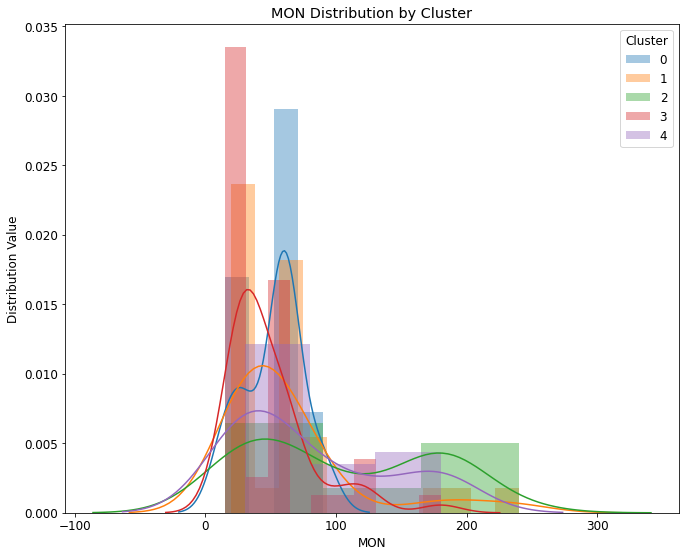

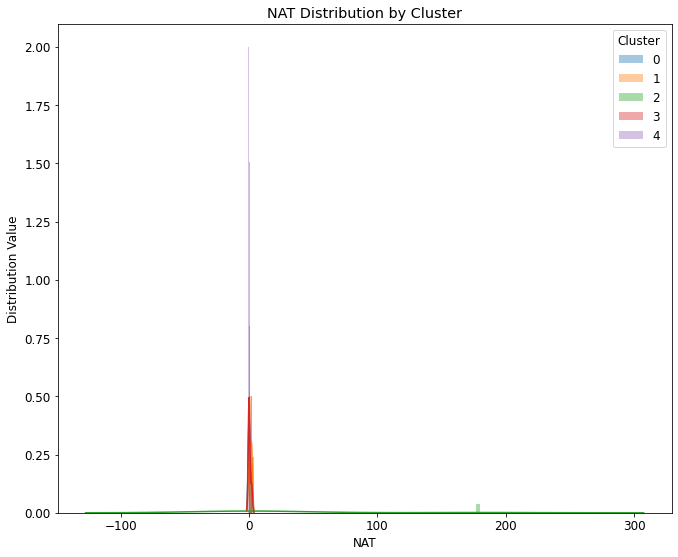

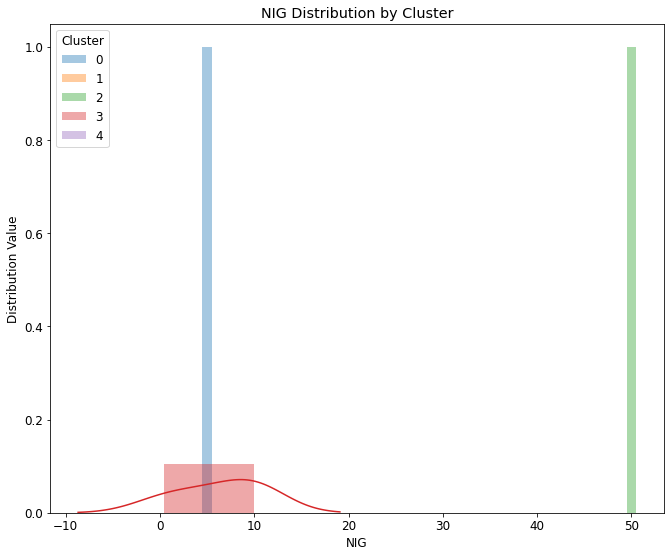

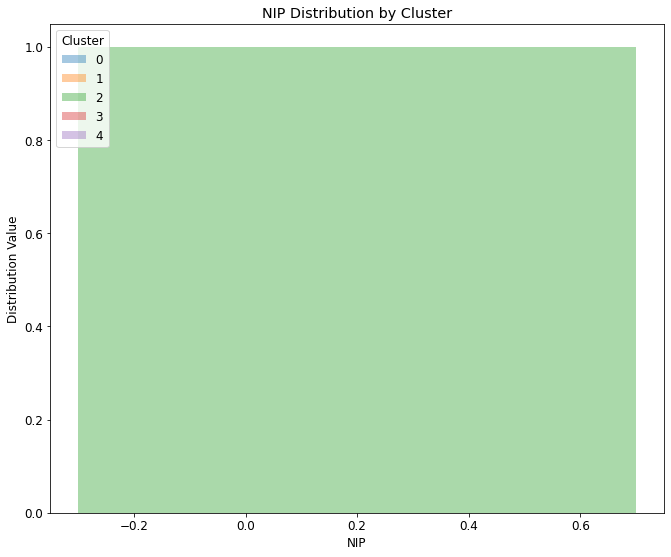

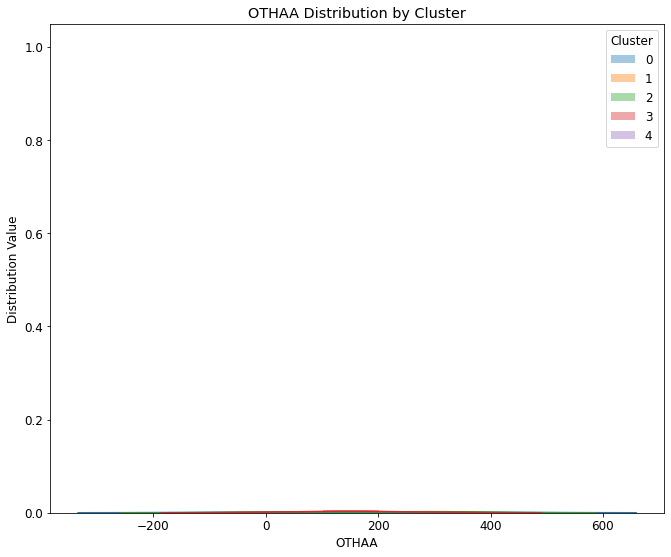

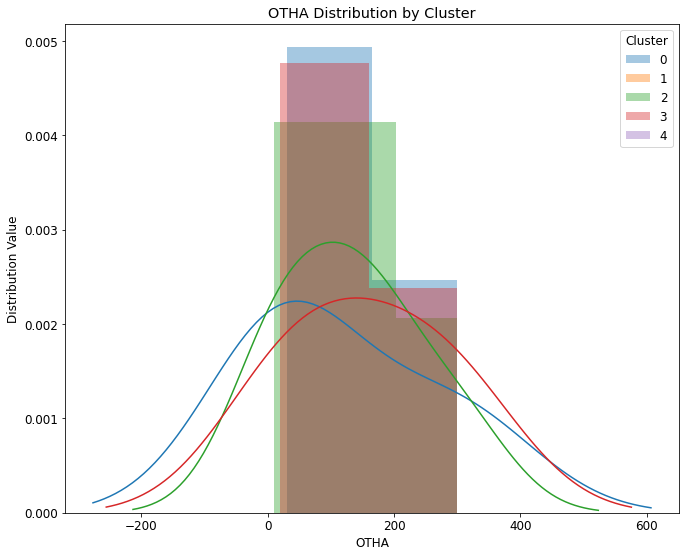

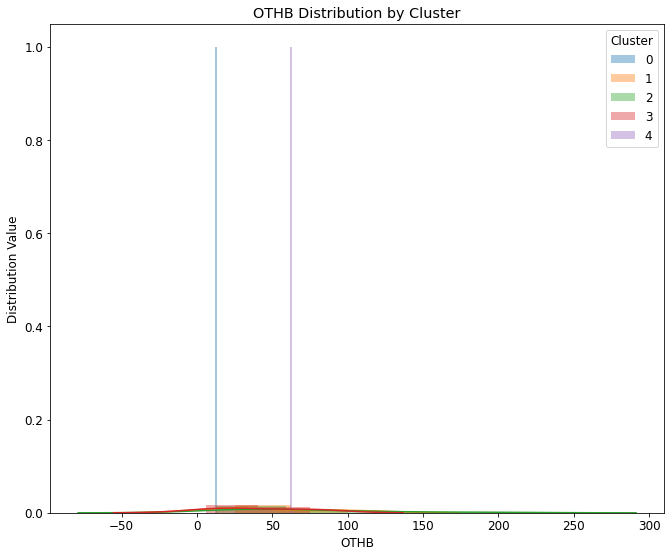

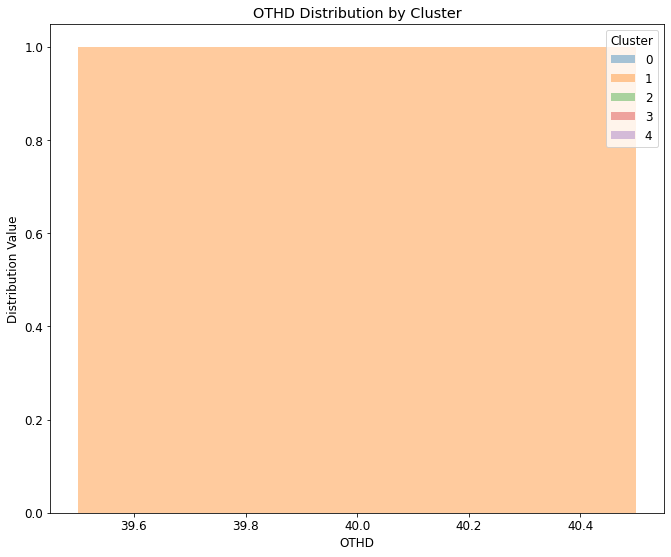

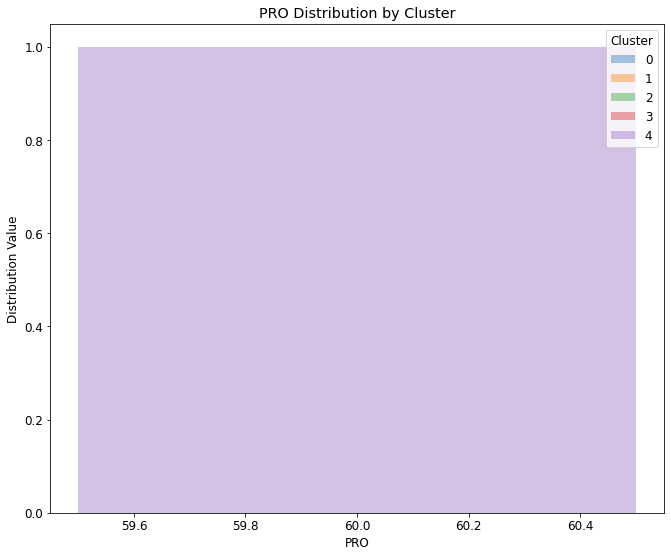

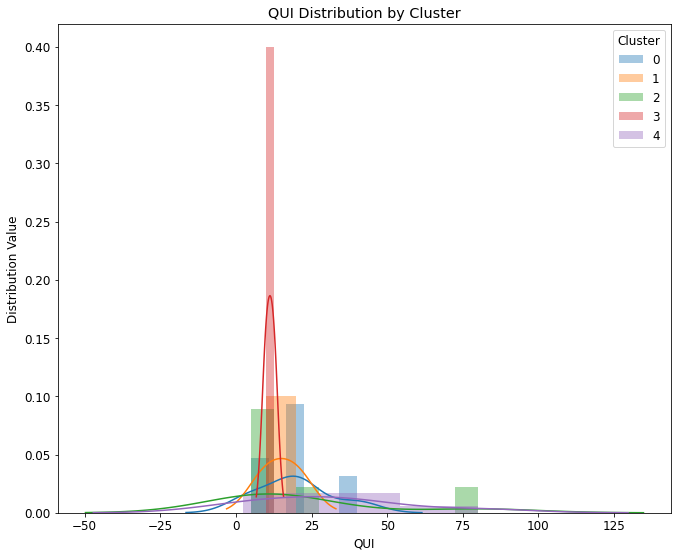

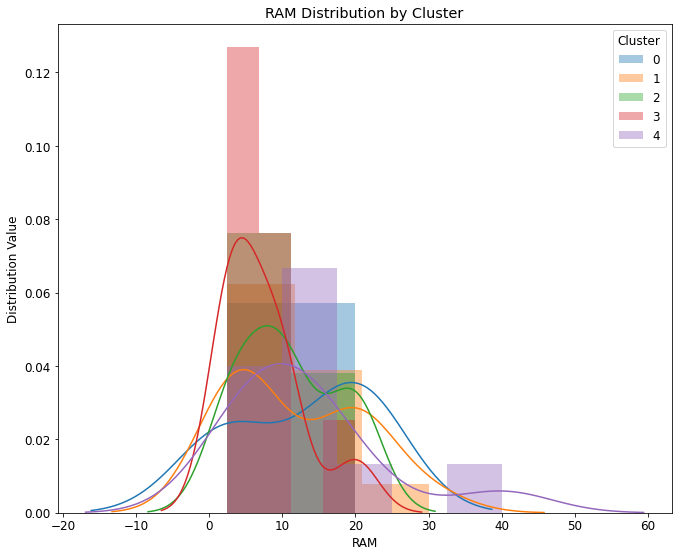

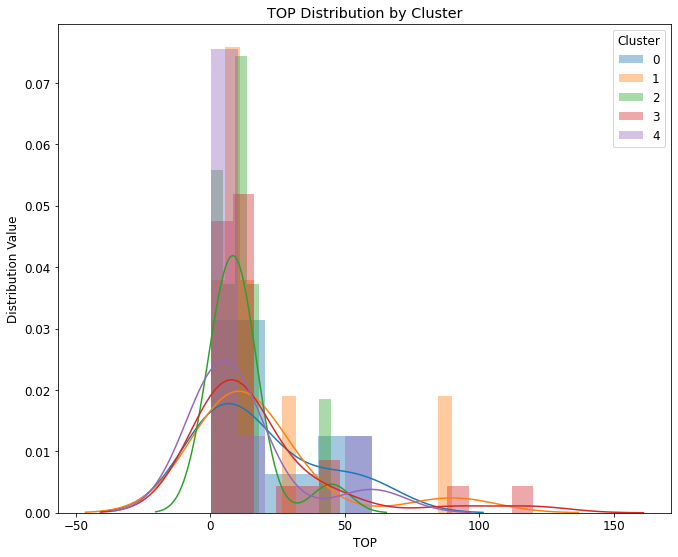

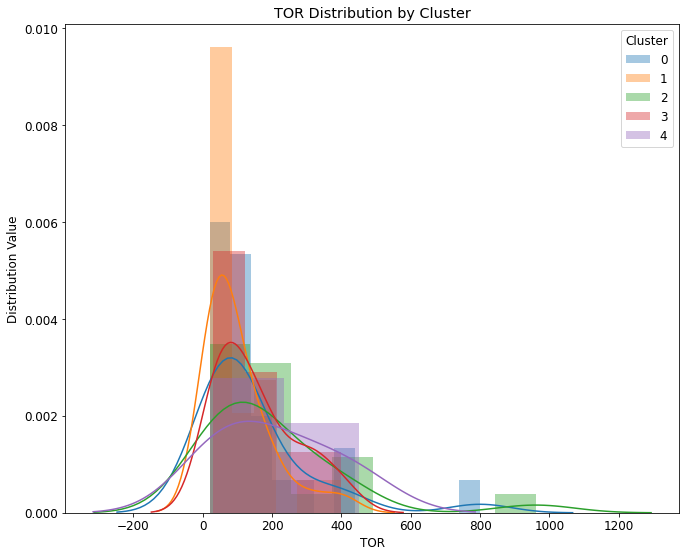

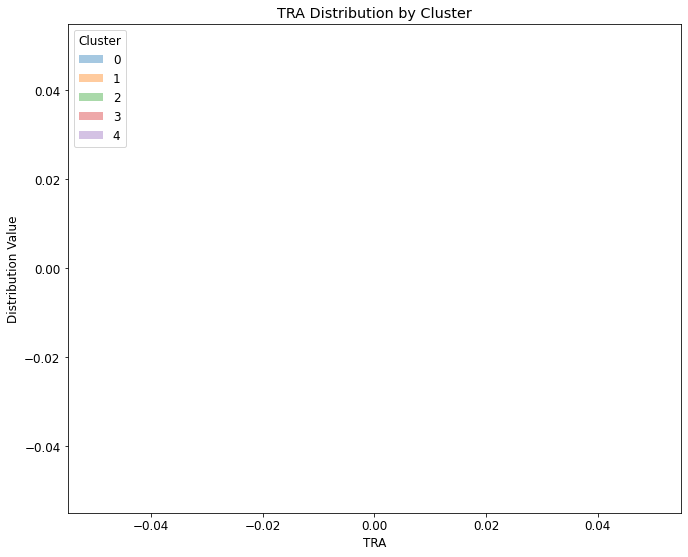

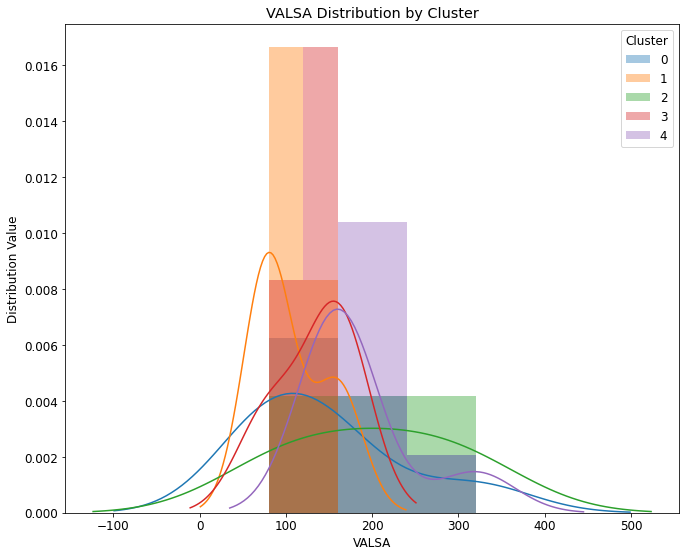

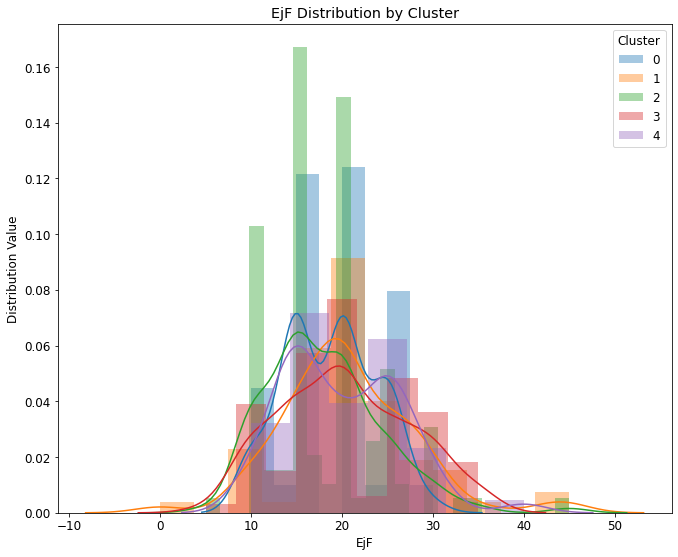

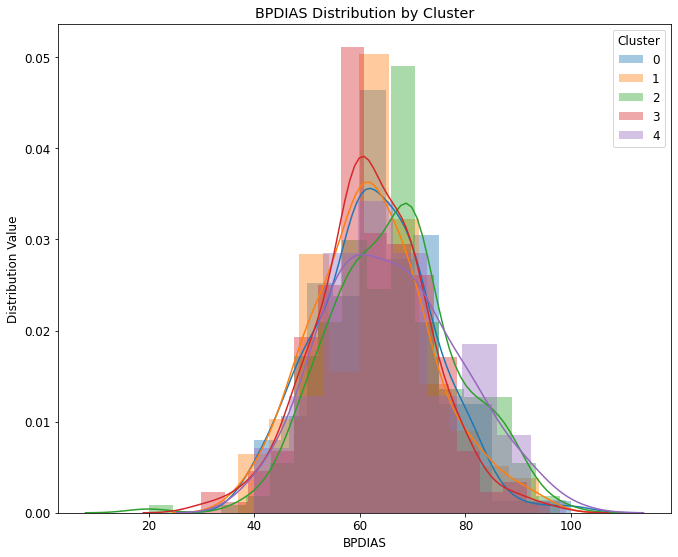

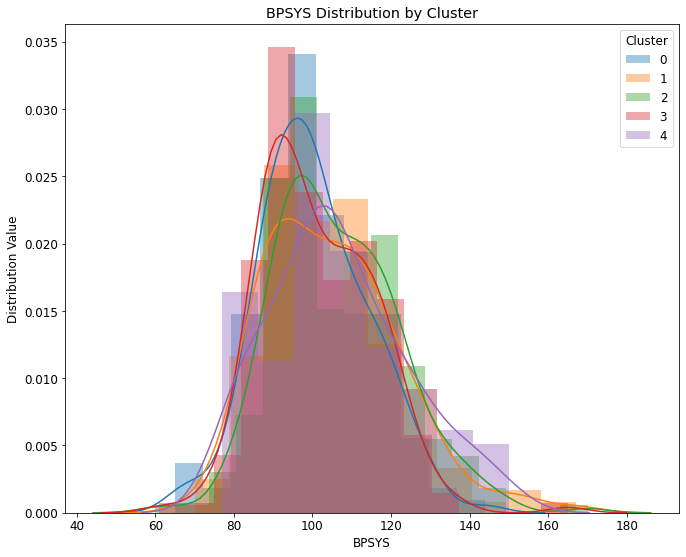

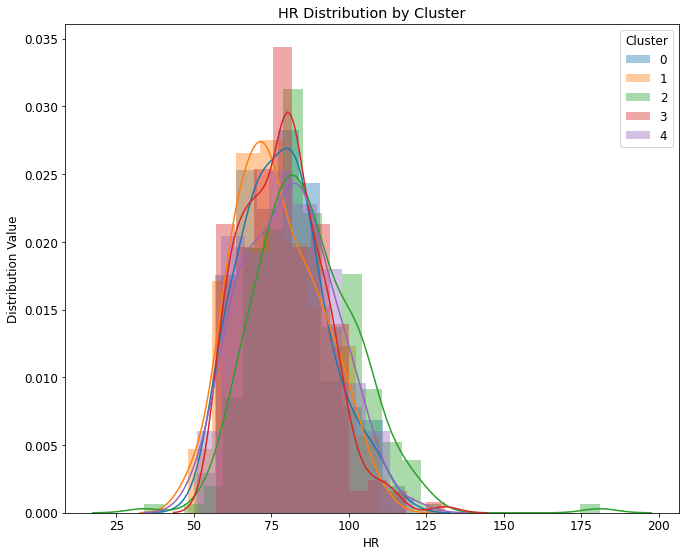

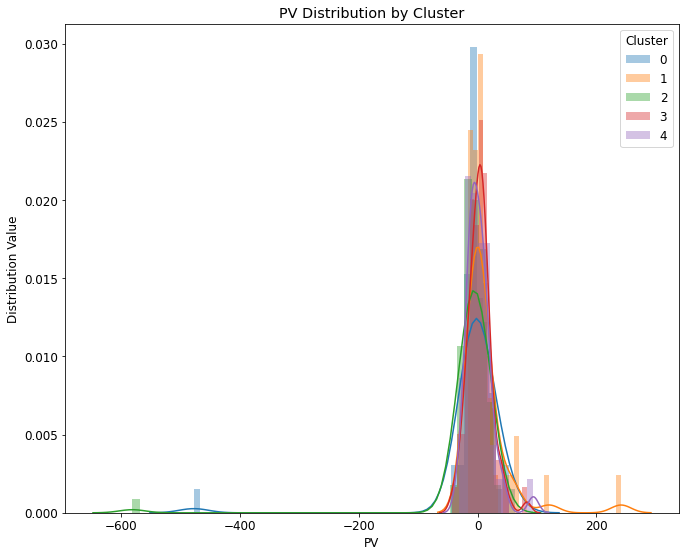

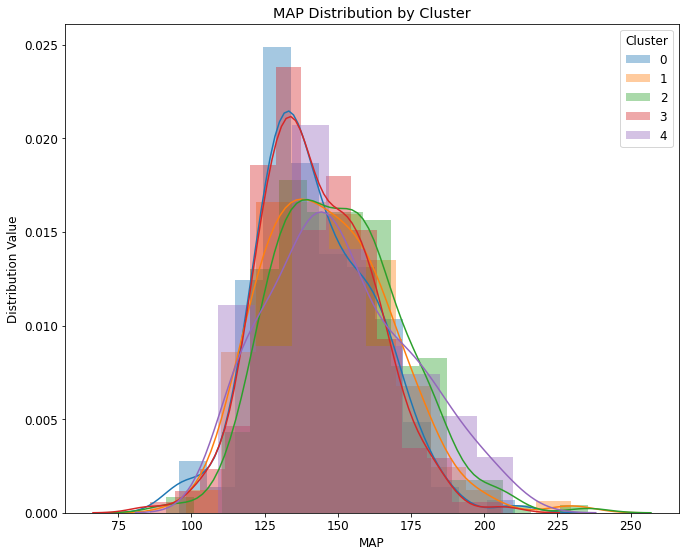

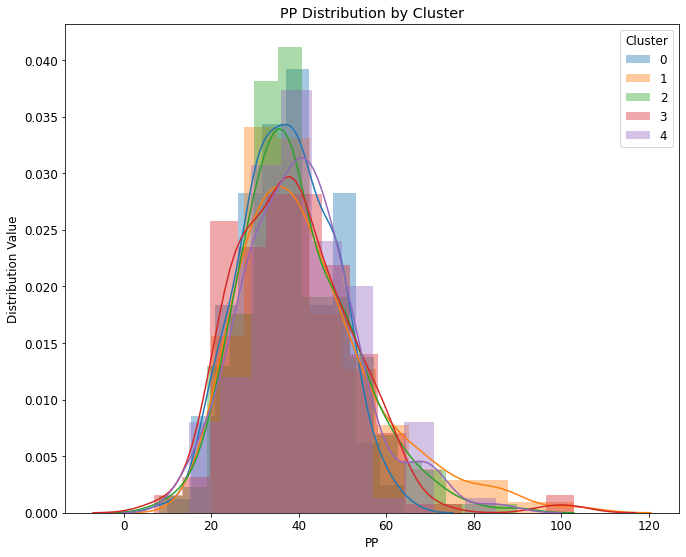

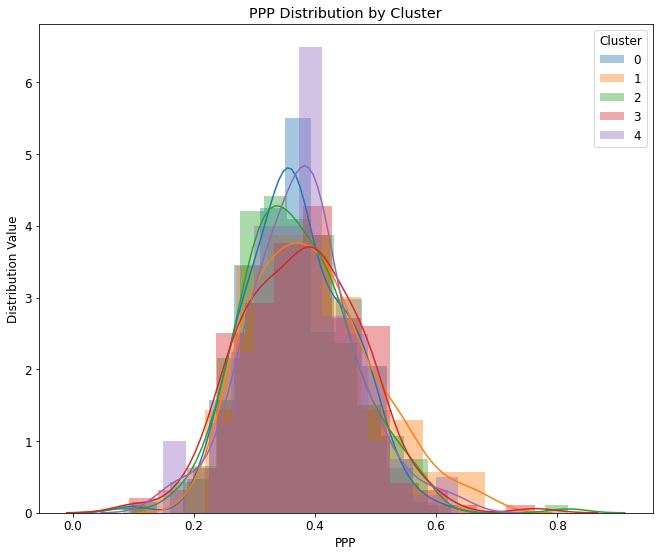

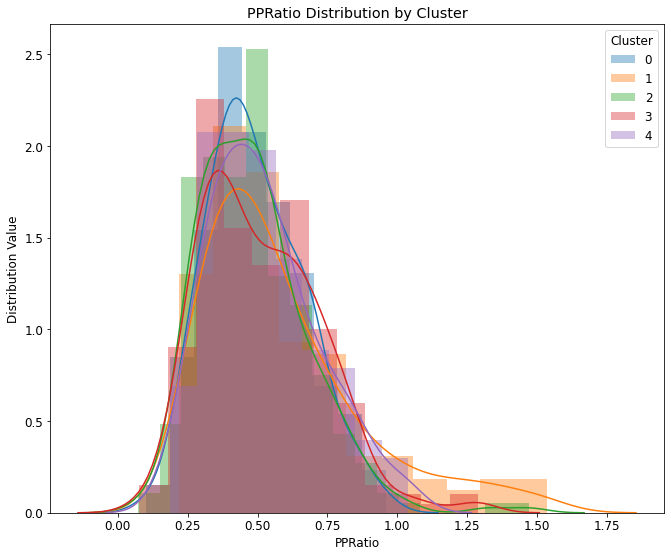

In [69]:
colss = ['Age', 'Gender', 'Race', 'Wt', 'BMI', 'InitialHospDays', 'TotalHospDays', 'NYHA', 'MLHFS', 'AF', 'AlchE', 'ANGP', 'AOREG', 'AOST', 'ARRH', 'CABG', 'CARREST', 'COPD', 'CVD', 'CYTOE', 'DEPR', 'DIAB', 'FAMILE', 'GOUT', 'HEPT', 'HTN', 'HYPERE', 'HTRANS', 'ICD', 'IDIOPE', 'ISCHD', 'ISCHEME', 'MALIG', 'MI', 'MTST', 'OTHUNE', 'PACE', 'PERIPAE', 'PMRG', 'PTCI', 'PTREG', 'PVD', 'RENALI', 'SMOKING', 'STERD', 'STROKE', 'SVT', 'TDP', 'TIA', 'VAHD', 'VALVUE', 'VF', 'SixFtWlk', 'VO2', 'ALB', 'ALT', 'AST', 'BUN', 'CRT', 'DIAL', 'HEC', 'HEM', 'PLA', 'POT', 'SOD', 'TALB', 'TOTP', 'WBC', 'ACE', 'BET', 'NIT', 'ANGIO', 'CINF', 'DIUR', 'AMR', 'ATE', 'BEN', 'BIS', 'BUM', 'CAND', 'CAP', 'CAR', 'DIGX', 'DIN', 'DOB', 'DOP', 'ENA', 'ETH', 'FOS', 'FUR', 'LIS', 'LOSA', 'MET', 'MIL', 'MON', 'NAT', 'NIG', 'NIP', 'OTHAA', 'OTHA', 'OTHB', 'OTHD', 'PRO', 'QUI', 'RAM', 'TOP', 'TOR', 'TRA', 'VALSA', 'EjF', 'BPDIAS', 'BPSYS', 'HR', 'PV', 'MAP', 'PP', 'PPP', 'PPRatio']

distPlotsForClusters(cls=clusters, cols=colss)

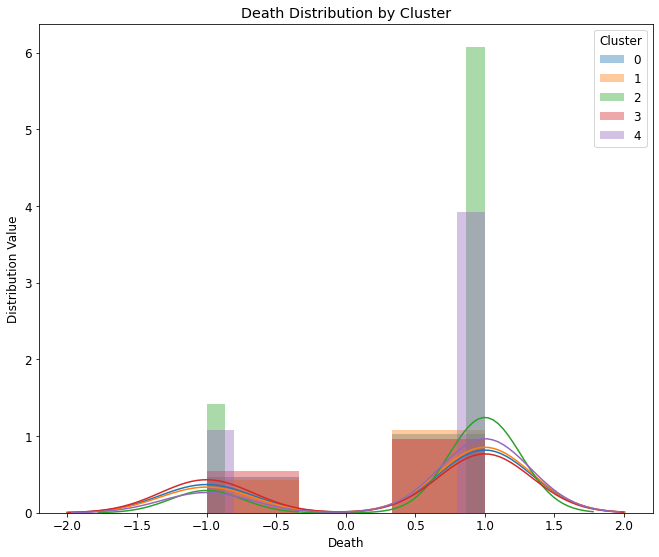

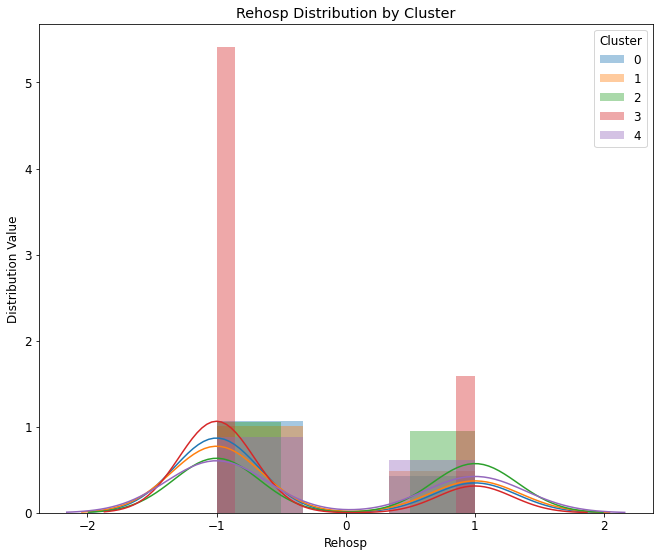

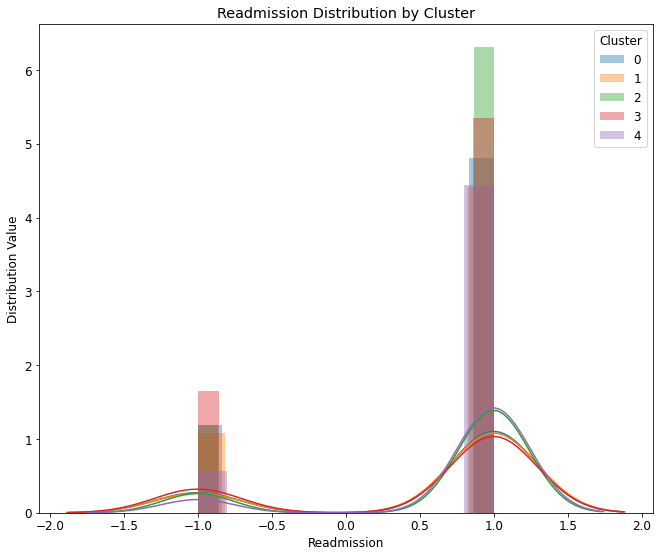

In [70]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss)

In [71]:

clsDict = {}
count = 1
clsOrder = [3,4,2,1,5]
for i in range(len(clusterDesc)):
    cluster = clusterDesc[clsOrder[i]-1]
    cluster = cluster.fillna(0)
    cluster = cluster.replace(np.inf, 0)
    for c in cluster:
        if count == 1:
            clsDict[c] = [cluster[c]['mean']]
        else:
            clsDict[c].append(cluster[c]['mean'])
    count+=1

clsDict

{'Age': [47.36363636363637,
  63.3448275862069,
  61.394366197183096,
  55.78260869565217,
  56.7196261682243],
 'Gender': [1.4189723320158103,
  1.1477832512315271,
  1.147887323943662,
  1.2608695652173914,
  1.233644859813084],
 'Race': [4.24901185770751,
  4.1330049261083746,
  2.795774647887324,
  3.8447204968944098,
  3.6448598130841123],
 'Wt': [83.1577786232636,
  83.49493970387756,
  84.13081193671756,
  86.8566198905369,
  79.1652565260396],
 'BMI': [29.027806400843886,
  27.26397329721053,
  28.464810185118107,
  29.37512948922535,
  27.408522750891088],
 'InitialHospDays': [7.2,
  9.346733668341708,
  8.707142857142857,
  9.656050955414013,
  7.710280373831775],
 'TotalHospDays': [14.225296442687746,
  19.625615763546797,
  15.485915492957746,
  18.888198757763973,
  14.102803738317757],
 'NYHA': [3.2904564315352696,
  3.4381443298969074,
  3.3970588235294117,
  3.414473684210526,
  3.2666666666666666],
 'MLHFS': [76.66666666666667,
  72.75384615384615,
  72.96428571428571,

In [72]:
#Save descriptive details from clusters

descSummary = pd.DataFrame()
for i in range(len(clusterDesc)):
    descSummary = descSummary.append(clusterDesc[i])
descSummary.to_csv("Cluster_Descriptions_AllData.csv")

In [73]:
allDF.to_csv("Clustered_allDataDF.csv")

Save preprocessed data  
Cluster --> Score  
0 --> 5  
1 --> 1 
2 --> 2  
3 --> 4  
4 --> 3  

In [76]:
#Save fully preprocessed score data
clusNums = allDF['cluster']

labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
    
allDF['Score'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreDeath'] = labels

#Rehosp Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(1)
    elif c == 2:
        labels.append(2)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreRehosp'] = labels

#Death Scores
labels = []
for c in clusNums:
    if c == 0:
        labels.append(5)
    elif c == 1:
        labels.append(2)
    elif c == 2:
        labels.append(1)
    elif c == 3:
        labels.append(4)
    elif c == 4:
        labels.append(3)
    else:
        pass
allDF['ScoreReadmission'] = labels

allDF = allDF.drop(columns=["cluster"])
allDF = allDF.drop(columns=["Death"])
allDF = allDF.drop(columns=["Rehosp"])
allDF = allDF.drop(columns=["Readmission"])

allDF

Age  Gender  Race          Wt        BMI  InitialHospDays  \
DEIDNUM                                                               
72       88.0     2.0   1.0   57.100000  26.424175              9.0   
72       88.0     2.0   1.0   52.000000  24.064047              9.0   
81       69.0     1.0   1.0  102.363636  32.307675              5.0   
81       69.0     1.0   1.0  100.454545  31.705134              5.0   
86       56.0     2.0   2.0   98.636364  40.016375              3.0   
...       ...     ...   ...         ...        ...              ...   
99302    41.0     1.0   2.0   97.400000  40.541103             21.0   
99912    46.0     1.0   1.0   78.636364  25.677180              2.0   
99912    46.0     1.0   1.0   78.200000  25.534694              2.0   
99935    64.0     2.0   1.0   77.700000  32.762692              3.0   
99935    64.0     2.0   1.0         NaN        NaN              3.0   

         TotalHospDays  NYHA  MLHFS   AF  ...     HR         PV         MAP  \
DEIDNUM                                   ...                                 
72                16.0   4.0   76.0  1.0  ...  104.0  12.452563  139.333333   
72                16.0   3.0   76.0  1.0  ...   92.0  12.452563  126.000000   
81                13.0   4.0   21.0  1.0  ...   70.0  -3.346568  125.333333   
81                13.0   2.0   21.0  1.0  ...   72.0  -3.346568  105.666667   
86                 3.0   4.0    NaN  0.0  ...   86.0   5.478621  146.666667   
...                ...   ...    ...  ...  ...    ...        ...         ...   
99302             21.0   NaN   79.0  0.0  ...   75.0  25.535155  130.000000   
99912              2.0   4.0   89.0  0.0  ...   67.0 -13.911732  174.666667   
99912              2.0   3.0   89.0  0.0  ...   60.0 -13.911732  140.666667   
99935             16.0   3.0  101.0  0.0  ...   86.0        NaN  135.333333   
99935             16.0   NaN  101.0  0.0  ...   87.0        NaN  153.333333   

           PP       PPP   PPRatio  Score  ScoreDeath  ScoreRehosp  \
DEIDNUM                                                             
72       26.0  0.276596  0.250000      4           4            4   
72       26.0  0.302326  0.282609      4           4            4   
81       32.0  0.363636  0.457143      5           5            5   
81       34.0  0.441558  0.472222      5           5            5   
86       30.0  0.300000  0.348837      2           2            2   
...       ...       ...       ...    ...         ...          ...   
99302    55.0  0.550000  0.733333      5           5            5   
99912    38.0  0.316667  0.567164      2           2            2   
99912    24.0  0.255319  0.400000      2           2            2   
99935    42.0  0.428571  0.488372      3           3            3   
99935    70.0  0.583333  0.804598      3           3            3   

         ScoreReadmission  
DEIDNUM                    
72                      4  
72                      4  
81                      5  
81                      5  
86                      1  
...                   ...  
99302                   5  
99912                   1  
99912                   1  
99935                   3  
99935                   3  

[866 rows x 122 columns]

In [77]:
allDF.to_csv("Preprocessed Data/Cluster_AllData.csv")

# Probability Labels

## Hemo

In [29]:
hemo = copy.deepcopy(hemoOrig)
hemo['Death'] = classLabels['Death']
hemo['Rehosp'] = classLabels['Rehosp']
hemo['Readmission'] = classLabels['Readmission']
hemo

RAP   PAS   PAD  PAMN   CWP  PCWPMod  PCWPA  PCWPMN    CO    CI  \
DEIDNUM                                                                     
72       24.0  42.0  24.0  30.0  36.0     36.0   36.0    36.0  2.20  1.60   
72       18.0  42.0  24.0  30.0  24.0     24.0   24.0    28.0  3.10  2.00   
81       10.0  40.0  20.0  27.0  18.0     18.0   18.0    20.0  4.52  2.02   
81       12.0  35.0  15.0  25.0  17.0     17.0   17.0    14.0  4.65  2.08   
814       3.0  51.0  19.0  30.0  18.0     18.0   18.0    18.0  4.10  2.00   
...       ...   ...   ...   ...   ...      ...    ...     ...   ...   ...   
98508     NaN   NaN   NaN   NaN   NaN      NaN    NaN     NaN   NaN   NaN   
99302    19.0  87.0  37.0  54.0  44.0     44.0   44.0     NaN  3.90  2.00   
99302    11.0  70.0  28.0  44.0  28.0     28.0   28.0     NaN  5.30  2.70   
99935     8.0  49.0  29.0  31.0  15.0     15.0   15.0    26.0  4.00  2.40   
99935     8.0  52.0  24.0  39.0  24.0     24.0   24.0    24.0  5.60  3.30   

         ...       PPP      PAPP           VR       RAT   PPRatio   Age   EjF  \
DEIDNUM  ...                                                                    
72       ...  0.245614  0.428571  5357.575758  0.666667  0.266667  88.0  25.0   
72       ...  0.235294  0.428571  3509.677419  0.750000  0.272727  88.0  25.0   
81       ...  0.212500  0.500000  1982.300885  0.555556  0.242857  69.0  20.0   
81       ...  0.470588  0.571429  1772.043011  0.705882  0.571429  69.0  20.0   
814      ...  0.354167  0.627451  2621.138211  0.166667  0.566667  58.0   NaN   
...      ...       ...       ...          ...       ...       ...   ...   ...   
98508    ...       NaN       NaN          NaN       NaN       NaN  57.0  30.0   
99302    ...  0.486486  0.574713  2666.666667  0.431818  0.642857  41.0  15.0   
99302    ...  0.623188  0.600000  2440.251572  0.392857  1.088608  41.0  15.0   
99935    ...  0.676259  0.408163  3220.000000  0.533333  1.253333  64.0  20.0   
99935    ...  0.615385  0.538462  1985.714286  0.333333  0.888889  64.0  20.0   

         Death  Rehosp  Readmission  
DEIDNUM                              
72          -1      -1            1  
72          -1      -1            1  
81           1      -1            1  
81           1      -1            1  
814          1       1            1  
...        ...     ...          ...  
98508        1       1            1  
99302       -1      -1            1  
99302       -1      -1            1  
99935        1      -1            1  
99935        1      -1            1  

[418 rows x 30 columns]

In [ ]:
#count time out of range(?)


In [103]:
hemoCounts = pd.read_csv('Feature_allData.csv')
hemoCounts

Variable  Total  Unnamed: 2        Variable.1  Death Total  \
0       TotalHospDays      6         NaN   InitialHospDays            2   
1               CRT_B      6         NaN     TotalHospDays            2   
2                PP_D      6         NaN                AF            2   
3           PPRatio_D      6         NaN             AOREG            2   
4     InitialHospDays      5         NaN              ARRH            2   
..                ...    ...         ...               ...          ...   
184             TRA_D      0         NaN            PP_Chg            0   
185                PV      0         NaN             PPP_B            0   
186           MAP_Chg      0         NaN           PPP_Chg            0   
187            PP_Chg      0         NaN         PPRatio_B            0   
188           PPP_Chg      0         NaN       PPRatio_Chg            0   

     Unnamed: 5        Variable.2  Rehosp Total  Unnamed: 8      Variable.3  \
0           NaN              Race             2         NaN           BMI_B   
1           NaN   InitialHospDays             2         NaN   TotalHospDays   
2           NaN     TotalHospDays             2         NaN         PERIPAE   
3           NaN                AF             2         NaN           BUN_D   
4           NaN              ARRH             2         NaN          CINF_D   
..          ...               ...           ...         ...             ...   
184         NaN                PV             0         NaN           MAP_D   
185         NaN           MAP_Chg             0         NaN         MAP_Chg   
186         NaN            PP_Chg             0         NaN          PP_Chg   
187         NaN             PPP_B             0         NaN         PPP_Chg   
188         NaN           PPP_Chg             0         NaN     PPRatio_Chg   

     Readmis Total  
0                2  
1                2  
2                2  
3                2  
4                2  
..             ...  
184              0  
185              0  
186              0  
187              0  
188              0  

[189 rows x 11 columns]

In [107]:
from collections import OrderedDict
ft = []
for v in hemoCounts['Variable.3']:
    v = v.replace("_D", "")
    v = v.replace("_B", "")
    v = v.replace("_Chg", "")
    v = v.replace(" ", "")
    ft.append(v)
    
finalFt = list(OrderedDict.fromkeys(ft))
print(finalFt)

['BMI', 'TotalHospDays', 'PERIPAE', 'BUN', 'CINF', 'DIN', 'MIL', 'NAT', 'TOR', 'PP', 'PPP', 'PPRatio', 'Age', 'IDIOPE', 'MALIG', 'OTHUNE', 'STERD', 'SixFtWlk', 'SixFtWlk_M3', 'SixFtWlk_M6', 'ALB', 'ALT', 'AST', 'CRT', 'DIAL', 'POT', 'SOD', 'TALB', 'TOTP', 'DIUR', 'BUM', 'DOP', 'ENA', 'FUR', 'MON', 'OTHA', 'OTHB', 'QUI', 'VALSA', 'EjF', 'BPDIAS', 'Gender', 'Race', 'Wt', 'InitialHospDays', 'AF', 'AlchE', 'ANGP', 'AOREG', 'AOST', 'ARRH', 'CABG', 'CARREST', 'COPD', 'CVD', 'CYTOE', 'DEPR', 'DIAB', 'FAMILE', 'GOUT', 'HEPT', 'HTN', 'HYPERE', 'HTRANS', 'ICD', 'ISCHD', 'ISCHEME', 'MI', 'MTST', 'PACE', 'PMRG', 'PTCI', 'PTREG', 'PVD', 'RENALI', 'SMOKING', 'STROKE', 'SVT', 'TDP', 'TIA', 'VAHD', 'VALVUE', 'VF', 'VO2', 'VO2_M3', 'HEC', 'HEM', 'PLA', 'WBC', 'ACE', 'BET', 'NIT', 'ANGIO', 'AMR', 'ATE', 'BEN', 'BIS', 'CAND', 'CAP', 'CAR', 'DIGX', 'DOB', 'ETH', 'FOS', 'LIS', 'LOSA', 'MET', 'NIG', 'NIP', 'OTHAA', 'OTHD', 'PRO', 'RAM', 'TOP', 'TRA', 'BPSYS', 'HR', 'PV', 'MAP']
